<a href="https://www.kaggle.com/code/dataranch/tiktok-popular-songs-feature-importance?scriptVersionId=106682409" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**TikTok Popular Songs Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

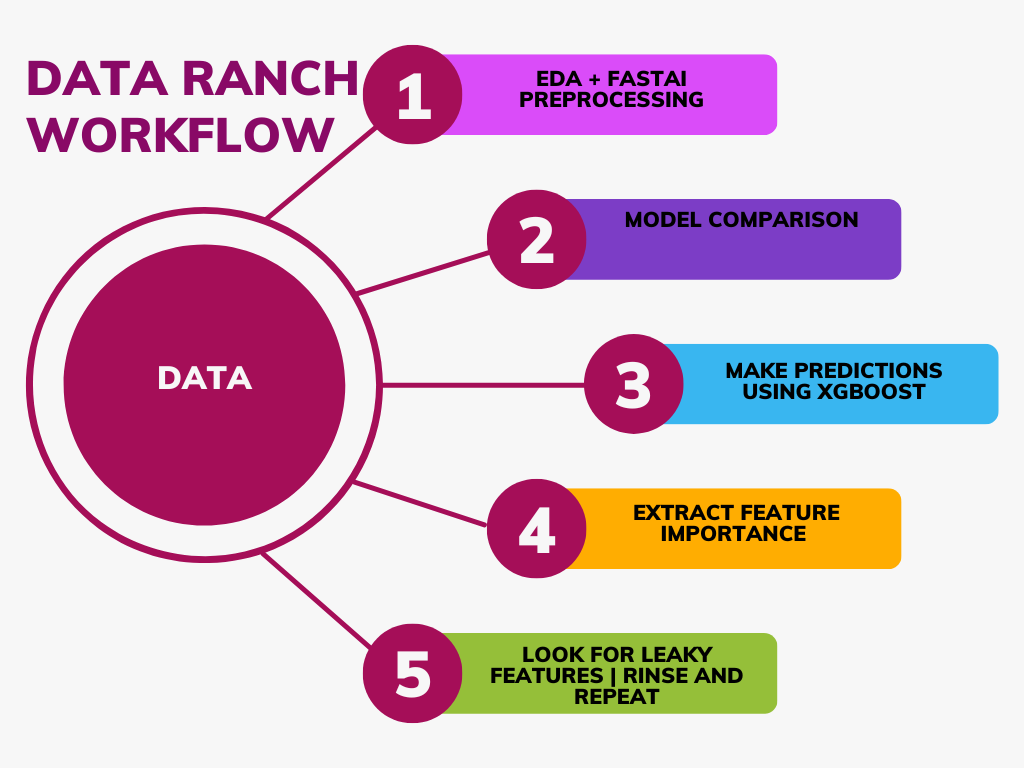

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 46.6 MB/s eta 0:00:00
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86

In [3]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,

In [6]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [7]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'tiktok-popular-songs-2020'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [8]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/tiktok-popular-songs-2020
CSV!


In [9]:
df

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Say So,Doja Cat,88,Hot Pink,80,0.79,0.67,-4.58,0,11,0.16,0.26,0.00,0.09,0.78,110.96,4,237893
1,Blinding Lights,The Weeknd,93,After Hours,90,0.51,0.73,-5.93,1,1,0.06,0.00,0.00,0.09,0.33,171.00,4,200040
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.86,0.63,-4.75,1,7,0.05,0.29,0.00,0.12,0.84,128.98,4,223488
3,Savage,Megan Thee Stallion,82,Suga,70,0.84,0.74,-5.61,1,11,0.33,0.03,0.00,0.10,0.68,168.98,4,155497
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.57,0.41,-8.62,1,10,0.04,0.59,0.00,0.10,0.27,119.81,4,201084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Buttons,The Pussycat Dolls,68,PCD,65,0.57,0.82,-4.38,1,2,0.27,0.18,0.00,0.29,0.41,210.86,4,225560
288,Get Busy,Sean Paul,79,Dutty Rock,74,0.73,0.82,-4.14,0,10,0.04,0.61,0.00,0.16,0.73,100.20,4,211666
289,ROCKSTAR (feat. Roddy Ricch),DaBaby,82,BLAME IT ON BABY,80,0.75,0.69,-7.96,1,11,0.16,0.25,0.00,0.10,0.50,89.98,4,181733
290,Who Says,Selena Gomez & The Scene,67,When The Sun Goes Down,76,0.68,0.93,-2.92,1,4,0.05,0.08,0.00,0.15,0.74,101.02,4,195613


In [10]:
df.isna().sum()

track_name          0
artist_name         0
artist_pop          0
album               0
track_pop           0
danceability        0
energy              0
loudness            0
mode                0
key                 0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
duration_ms         0
dtype: int64

<AxesSubplot:>

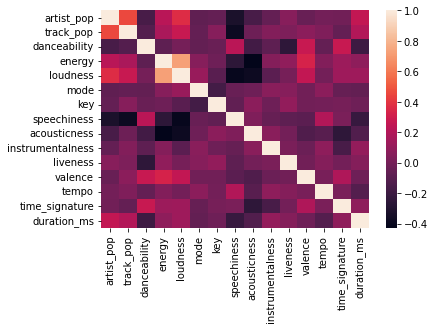

In [11]:
sns.heatmap(df.corr())

In [12]:
df.head().style.background_gradient(cmap = "inferno")

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Say So,Doja Cat,88,Hot Pink,80,0.79,0.67,-4.58,0,11,0.16,0.26,0.00,0.09,0.78,110.96,4,237893
1,Blinding Lights,The Weeknd,93,After Hours,90,0.51,0.73,-5.93,1,1,0.06,0.00,0.00,0.09,0.33,171.00,4,200040
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.86,0.63,-4.75,1,7,0.05,0.29,0.00,0.12,0.84,128.98,4,223488
3,Savage,Megan Thee Stallion,82,Suga,70,0.84,0.74,-5.61,1,11,0.33,0.03,0.00,0.10,0.68,168.98,4,155497
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.57,0.41,-8.62,1,10,0.04,0.59,0.00,0.10,0.27,119.81,4,201084


In [13]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
artist_pop,292.00,67.32,16.57,0.00,57.75,69.00,80.00,95.00
track_pop,292.00,61.20,20.78,0.00,57.00,66.00,74.00,90.00
danceability,292.00,0.73,0.14,0.17,0.65,0.73,0.83,0.98
energy,292.00,0.61,0.16,0.05,0.49,0.63,0.73,0.95
loudness,292.00,-6.88,2.70,-23.93,-8.37,-6.52,-4.98,-2.61
mode,292.00,0.53,0.50,0.00,0.00,1.00,1.00,1.00
key,292.00,5.04,3.69,0.00,1.00,5.00,8.00,11.00
speechiness,292.00,0.15,0.15,0.03,0.05,0.08,0.22,0.91
acousticness,292.00,0.23,0.26,0.00,0.03,0.13,0.33,0.97
instrumentalness,292.00,0.03,0.11,0.00,0.00,0.00,0.00,0.86


In [14]:
df.columns

Index(['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop',
       'danceability', 'energy', 'loudness', 'mode', 'key', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'duration_ms'],
      dtype='object')

Target Variable: duration_ms
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.04303276044619819, 'Adjusted R-Squared': -0.10097902491543143, 'RMSE': 66695.28851770506, 'Time taken': 0.02813577651977539}
{'Model': 'BaggingRegressor', 'R-Squared': -0.17382526115796537, 'Adjusted R-Squared': -0.23903777566674123, 'RMSE': 70753.49649382995, 'Time taken': 0.0277554988861084}
{'Model': 'BayesianRidge', 'R-Squared': -0.010639420057375615, 'Adjusted R-Squared': -0.06678605450500763, 'RMSE': 65651.44628139824, 'Time taken': 0.009490728378295898}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.21913472606899864, 'Adjusted R-Squared': -0.2868644330728318, 'RMSE': 72106.10421836804, 'Time taken': 0.008906841278076172}
{'Model': 'DummyRegressor', 'R-Squared': -0.010639409822359447, 'Adjusted R-Squared': -0.06678604370137942, 'RMSE': 65651.445, 'Time taken': 0.009119749069213867}
{'Model': 'ElasticNet', 'R-Squared': -0.00018305873074253576, 'Adjusted R-Squared': -0.055748784215783775, 'RMSE': 65310.939028075176, 'Time taken': 

 17%|█▋        | 7/42 [00:00<00:00, 45.99it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.01063942141366736, 'Adjusted R-Squared': -0.06678605593664888, 'RMSE': 65651.4463254508, 'Time taken': 0.059020280838012695}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.1855484606503086, 'Adjusted R-Squared': -0.25141226401977024, 'RMSE': 71105.9325313501, 'Time taken': 0.010815858840942383}


 29%|██▊       | 12/42 [00:00<00:00, 35.85it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.16489514714724796, 'Adjusted R-Squared': -0.22961154421098406, 'RMSE': 70483.84686584557, 'Time taken': 0.11084485054016113}
{'Model': 'GammaRegressor', 'R-Squared': -0.0024302157491662424, 'Adjusted R-Squared': -0.058120783290786626, 'RMSE': 65384.26640095006, 'Time taken': 0.010699987411499023}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.11499515240740998, 'Adjusted R-Squared': -0.17693932754115504, 'RMSE': 68957.68457748169, 'Time taken': 0.020272254943847656}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.002586114847486165, 'Adjusted R-Squared': -0.05828534345012426, 'RMSE': 65389.35052138388, 'Time taken': 0.015625715255737305}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.08265837929669706, 'Adjusted R-Squared': -0.14280606703540255, 'RMSE': 67950.38186272918, 'Time taken': 0.09542608261108398}


 38%|███▊      | 16/42 [00:00<00:01, 24.21it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.06387841260175264, 'Adjusted R-Squared': -0.12298276885740567, 'RMSE': 67358.46462454744, 'Time taken': 0.1308887004852295}
{'Model': 'HuberRegressor', 'R-Squared': -0.017285312560285204, 'Adjusted R-Squared': -0.07380116325807884, 'RMSE': 65866.95218038998, 'Time taken': 0.01743149757385254}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.2007856024133572, 'Adjusted R-Squared': -0.26749591365854375, 'RMSE': 71561.414, 'Time taken': 0.012145757675170898}
{'Model': 'KernelRidge', 'R-Squared': -9.204807538545772, 'Adjusted R-Squared': -9.771741290687205, 'RMSE': 208616.46890016773, 'Time taken': 0.016054391860961914}
{'Model': 'Lars', 'R-Squared': 0.00415798734640882, 'Adjusted R-Squared': -0.05116656891212412, 'RMSE': 65169.05195188139, 'Time taken': 0.015449762344360352}


 50%|█████     | 21/42 [00:00<00:00, 27.66it/s]

{'Model': 'LarsCV', 'R-Squared': -0.01063942141366736, 'Adjusted R-Squared': -0.06678605593664888, 'RMSE': 65651.4463254508, 'Time taken': 0.021152496337890625}
{'Model': 'Lasso', 'R-Squared': 0.0041507171335232185, 'Adjusted R-Squared': -0.051174243025725596, 'RMSE': 65169.289837013006, 'Time taken': 0.01304173469543457}
{'Model': 'LassoCV', 'R-Squared': -0.01063942141366736, 'Adjusted R-Squared': -0.06678605593664888, 'RMSE': 65651.4463254508, 'Time taken': 0.07351922988891602}
{'Model': 'LassoLars', 'R-Squared': 0.004046617265347718, 'Adjusted R-Squared': -0.05128412621991085, 'RMSE': 65172.695943396204, 'Time taken': 0.011345386505126953}
{'Model': 'LassoLarsCV', 'R-Squared': -0.01063942141366736, 'Adjusted R-Squared': -0.06678605593664888, 'RMSE': 65651.4463254508, 'Time taken': 0.018843412399291992}
{'Model': 'LassoLarsIC', 'R-Squared': -0.01063942141366736, 'Adjusted R-Squared': -0.06678605593664888, 'RMSE': 65651.4463254508, 'Time taken': 0.010937690734863281}
{'Model': 'Linear

 76%|███████▌  | 32/42 [00:01<00:00, 17.71it/s]

{'Model': 'MLPRegressor', 'R-Squared': -9.208205828647992, 'Adjusted R-Squared': -9.775328374683992, 'RMSE': 208651.2015625833, 'Time taken': 0.7059342861175537}
{'Model': 'NuSVR', 'R-Squared': -0.016693564144918405, 'Adjusted R-Squared': -0.07317653993074713, 'RMSE': 65847.79219947544, 'Time taken': 0.019970417022705078}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.006602974466388467, 'Adjusted R-Squared': -0.0625253619367434, 'RMSE': 65520.21074220971, 'Time taken': 0.014051437377929688}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.006602974466388467, 'Adjusted R-Squared': -0.0625253619367434, 'RMSE': 65520.21074220971, 'Time taken': 0.02030634880065918}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.11024338091802477, 'Adjusted R-Squared': -0.17192356874680392, 'RMSE': 68810.58931275104, 'Time taken': 0.03545093536376953}
{'Model': 'PoissonRegressor', 'R-Squared': 0.004403493701476191, 'Adjusted R-Squared': -0.05090742331510856, 'RMSE': 65161.018346944

100%|██████████| 42/42 [00:01<00:00, 21.88it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.20706212328651663, 'Adjusted R-Squared': -0.27412113013576755, 'RMSE': 71748.19702954343, 'Time taken': 0.14474773406982422}
{'Model': 'Ridge', 'R-Squared': 0.004107159946075356, 'Adjusted R-Squared': -0.05122022005692051, 'RMSE': 65170.71503256403, 'Time taken': 0.009976863861083984}
{'Model': 'RidgeCV', 'R-Squared': 0.003663068326300256, 'Adjusted R-Squared': -0.05168898343334982, 'RMSE': 65185.243976595586, 'Time taken': 0.009813547134399414}
{'Model': 'SGDRegressor', 'R-Squared': 0.003710620573125434, 'Adjusted R-Squared': -0.0516387893950343, 'RMSE': 65183.68840754147, 'Time taken': 0.010594367980957031}
{'Model': 'SVR', 'R-Squared': -0.022005084653860862, 'Adjusted R-Squared': -0.07878314491240879, 'RMSE': 66019.57271303692, 'Time taken': 0.012298345565795898}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.00415798734640882, 'Adjusted R-Squared': -0.05116656891212412, 'RMSE': 65169.05195188139, 'Time taken': 0.00908207893

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,37732732928.000000,43549102080.000000,208684.218750,00:00
1,38263861248.000000,43548012544.000000,208681.609375,00:00
2,38955487232.000000,43543560192.000000,208670.937500,00:00
3,38845272064.000000,43524673536.000000,208625.671875,00:00
4,38913843200.000000,43464077312.000000,208480.406250,00:00
5,38727389184.000000,43314929664.000000,208122.390625,00:00
6,38996692992.000000,43011727360.000000,207392.687500,00:00
7,38993403904.000000,42803519488.000000,206890.109375,00:00
8,39092465664.000000,42543480832.000000,206260.703125,00:00
9,38873255936.000000,42333827072.000000,205751.859375,00:00


Better model found at epoch 0 with _rmse value: 208684.21875.
Better model found at epoch 1 with _rmse value: 208681.609375.
Better model found at epoch 2 with _rmse value: 208670.9375.
Better model found at epoch 3 with _rmse value: 208625.671875.
Better model found at epoch 4 with _rmse value: 208480.40625.
Better model found at epoch 5 with _rmse value: 208122.390625.
Better model found at epoch 6 with _rmse value: 207392.6875.
Better model found at epoch 7 with _rmse value: 206890.109375.
Better model found at epoch 8 with _rmse value: 206260.703125.
Better model found at epoch 9 with _rmse value: 205751.859375.
Better model found at epoch 10 with _rmse value: 204705.828125.
Better model found at epoch 11 with _rmse value: 203960.03125.
Better model found at epoch 12 with _rmse value: 203447.03125.
No improvement since epoch 12: early stopping


,mode,key,time_signature,duration_ms,duration_ms_pred
0,2.00,1.00,3.00,162547.00,5538.06
1,2.00,1.00,3.00,208867.00,5538.06
2,2.00,9.00,3.00,234093.00,4436.24
3,2.00,9.00,3.00,204760.00,4436.24
4,1.00,1.00,3.00,266840.00,6109.49
5,2.00,11.00,3.00,115352.00,5753.45
6,2.00,8.00,3.00,197213.00,4657.26
7,2.00,2.00,3.00,281313.00,5828.06
8,2.00,6.00,3.00,196893.00,5883.67


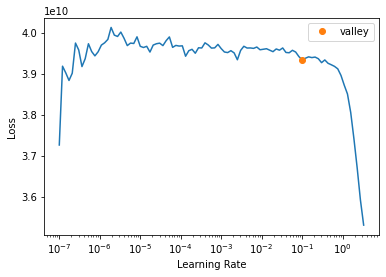

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 133995.00  200454.42
1 204760.00  191858.75
2  83940.00  233904.39
3 177866.00  194161.31
4 215200.00  226788.67
XGBoost RMSE:  71429.05


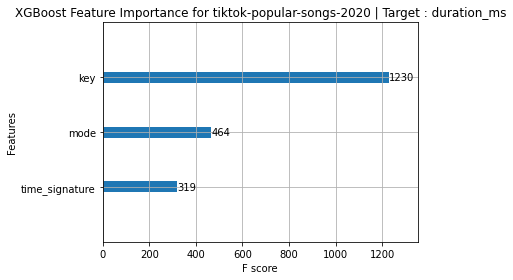

Target Variable: time_signature
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
19
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.4830408058990363, 'Adjusted R-Squared': -0.5369695624771831, 'RMSE': 0.30858544109735775, 'Time taken': 0.020987749099731445}
{'Model': 'BaggingRegressor', 'R-Squared': -0.13352572123751183, 'Adjusted R-Squared': -0.17474483837342136, 'RMSE': 0.26978299498645064, 'Time taken': 0.02624678611755371}
{'Model': 'BayesianRidge', 'R-Squared': -0.03498494277451347, 'Adjusted R-Squared': -0.07262075887540487, 'RMSE': 0.2577898998662216, 'Time taken': 0.009227514266967773}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.17041498698244695, 'Adjusted R-Squared': -0.21297553196362684, 'RMSE': 0.2741377343244841, 'Time taken': 0.008805036544799805}
{'Model': 'DummyRegressor', 'R-Squared': -0.010715551551258917, 'Adjusted R-Squared': -0.04746884433494114, 'RMSE': 0.2547495092553387, 'Time taken': 0.007923603057861328}
{'Model': 'ElasticNet', 'R-Squared': -0.010715551551258917, 'Adjusted R-Squared': -0.04746884433494114, 'RMSE': 0.2547495092553387, 'T

 17%|█▋        | 7/42 [00:00<00:00, 49.45it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.07975121931503093, 'Adjusted R-Squared': -0.11901490001739568, 'RMSE': 0.26330598667617583, 'Time taken': 0.05932974815368652}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.17041498698244695, 'Adjusted R-Squared': -0.21297553196362684, 'RMSE': 0.2741377343244841, 'Time taken': 0.011162281036376953}


 29%|██▊       | 12/42 [00:00<00:00, 35.33it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.17041498698244517, 'Adjusted R-Squared': -0.21297553196362506, 'RMSE': 0.27413773432448385, 'Time taken': 0.10640931129455566}
{'Model': 'GammaRegressor', 'R-Squared': -0.037524928339540686, 'Adjusted R-Squared': -0.07525310755188763, 'RMSE': 0.2581060307390102, 'Time taken': 0.0111236572265625}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.17890295796162947, 'Adjusted R-Squared': -0.22177215643296155, 'RMSE': 0.2751299762668188, 'Time taken': 0.02296137809753418}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.0374576726590401, 'Adjusted R-Squared': -0.07518340621027786, 'RMSE': 0.2580976649746841, 'Time taken': 0.02809929847717285}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.16844623040735618, 'Adjusted R-Squared': -0.21093518424035107, 'RMSE': 0.2739070735648627, 'Time taken': 0.09874176979064941}


 38%|███▊      | 16/42 [00:00<00:01, 24.01it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.13712842329209884, 'Adjusted R-Squared': -0.1784785477754478, 'RMSE': 0.270211382568624, 'Time taken': 0.11343598365783691}
{'Model': 'HuberRegressor', 'R-Squared': -0.07407407441218039, 'Adjusted R-Squared': -0.11313131348171424, 'RMSE': 0.2626128657607789, 'Time taken': 0.03148627281188965}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.18148148148148158, 'Adjusted R-Squared': -0.22444444444444467, 'RMSE': 0.27543069720987395, 'Time taken': 0.010475635528564453}
{'Model': 'KernelRidge', 'R-Squared': -132.98192015263893, 'Adjusted R-Squared': -137.85398997637125, 'RMSE': 2.9330669805338343, 'Time taken': 0.031644344329833984}


 45%|████▌     | 19/42 [00:00<00:00, 25.04it/s]

{'Model': 'Lars', 'R-Squared': -0.07989384720952719, 'Adjusted R-Squared': -0.11916271438078274, 'RMSE': 0.2633233765793843, 'Time taken': 0.02955150604248047}
{'Model': 'LarsCV', 'R-Squared': -0.07989384720952719, 'Adjusted R-Squared': -0.11916271438078274, 'RMSE': 0.2633233765793843, 'Time taken': 0.04126143455505371}
{'Model': 'Lasso', 'R-Squared': -0.010715551551258917, 'Adjusted R-Squared': -0.04746884433494114, 'RMSE': 0.2547495092553387, 'Time taken': 0.02661418914794922}


 52%|█████▏    | 22/42 [00:00<00:00, 25.72it/s]

{'Model': 'LassoCV', 'R-Squared': -0.07975435335645509, 'Adjusted R-Squared': -0.11901814802396249, 'RMSE': 0.2633063688064554, 'Time taken': 0.06502079963684082}
{'Model': 'LassoLars', 'R-Squared': -0.010715551551258917, 'Adjusted R-Squared': -0.04746884433494114, 'RMSE': 0.2547495092553387, 'Time taken': 0.009531021118164062}
{'Model': 'LassoLarsCV', 'R-Squared': -0.07989384720952719, 'Adjusted R-Squared': -0.11916271438078274, 'RMSE': 0.2633233765793843, 'Time taken': 0.015723705291748047}
{'Model': 'LassoLarsIC', 'R-Squared': -0.03920275214632318, 'Adjusted R-Squared': -0.07699194313346225, 'RMSE': 0.2583146433199432, 'Time taken': 0.010070085525512695}
{'Model': 'LinearRegression', 'R-Squared': -0.07989384720952719, 'Adjusted R-Squared': -0.11916271438078274, 'RMSE': 0.2633233765793843, 'Time taken': 0.009261608123779297}
{'Model': 'LinearSVR', 'R-Squared': -0.07407407407520017, 'Adjusted R-Squared': -0.11313131313248026, 'RMSE': 0.2626128657195828, 'Time taken': 0.012793064117431

 79%|███████▊  | 33/42 [00:01<00:00, 17.83it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.6284232907047616, 'Adjusted R-Squared': -0.6876386830940255, 'RMSE': 0.32335719932728596, 'Time taken': 0.6287024021148682}
{'Model': 'NuSVR', 'R-Squared': -0.0740118303925732, 'Adjusted R-Squared': -0.11306680604321229, 'RMSE': 0.2626052562682955, 'Time taken': 0.016000747680664062}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.05730682212057814, 'Adjusted R-Squared': -0.09575434292496277, 'RMSE': 0.2605549925739013, 'Time taken': 0.013816118240356445}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.05730682212057814, 'Adjusted R-Squared': -0.09575434292496277, 'RMSE': 0.2605549925739013, 'Time taken': 0.018857955932617188}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.12281821041117369, 'Adjusted R-Squared': -0.16364796351703448, 'RMSE': 0.2685057594915735, 'Time taken': 0.014200687408447266}
{'Model': 'PoissonRegressor', 'R-Squared': -0.05623574730569003, 'Adjusted R-Squared': -0.09464431993498779, 'RMSE': 0.26042

100%|██████████| 42/42 [00:01<00:00, 22.32it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.15798660480480353, 'Adjusted R-Squared': -0.20009520861588737, 'RMSE': 0.27267834526338164, 'Time taken': 0.1452503204345703}
{'Model': 'Ridge', 'R-Squared': -0.07944858720136638, 'Adjusted R-Squared': -0.11870126309959783, 'RMSE': 0.2632690844573349, 'Time taken': 0.00926828384399414}
{'Model': 'RidgeCV', 'R-Squared': -0.07567346332194913, 'Adjusted R-Squared': -0.11478886198820182, 'RMSE': 0.26280831962650114, 'Time taken': 0.008989095687866211}
{'Model': 'SGDRegressor', 'R-Squared': -0.06992565878239088, 'Adjusted R-Squared': -0.10883204637447785, 'RMSE': 0.26210522792279045, 'Time taken': 0.010197877883911133}
{'Model': 'SVR', 'R-Squared': -0.12043783851948797, 'Adjusted R-Squared': -0.1611810326474694, 'RMSE': 0.2682209927047649, 'Time taken': 0.009612798690795898}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.07989384720952719, 'Adjusted R-Squared': -0.11916271438078274, 'RMSE': 0.2633233765793843, 'Time taken': 0.00911

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,5.917792,5.781148,2.404402,00:00
1,4.669281,3.103902,1.761790,00:00
2,4.448334,2.499907,1.581109,00:00
3,5.572835,2.138735,1.462441,00:00
4,4.988679,1.375631,1.172873,00:00
5,4.332720,1.736967,1.317941,00:00


Better model found at epoch 0 with _rmse value: 2.4044017791748047.
Better model found at epoch 1 with _rmse value: 1.7617895603179932.
Better model found at epoch 2 with _rmse value: 1.5811094045639038.
Better model found at epoch 3 with _rmse value: 1.4624414443969727.
Better model found at epoch 4 with _rmse value: 1.1728729009628296.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.10
1       3       2.71
2       3       3.00
3       3       3.00
4       3       2.80
XGBoost RMSE:  0.27402198


<Figure size 432x288 with 0 Axes>

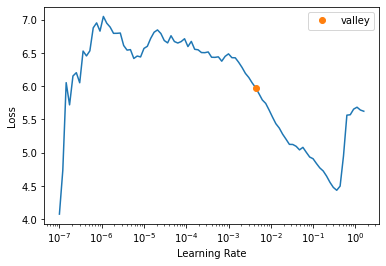

<Figure size 720x720 with 0 Axes>

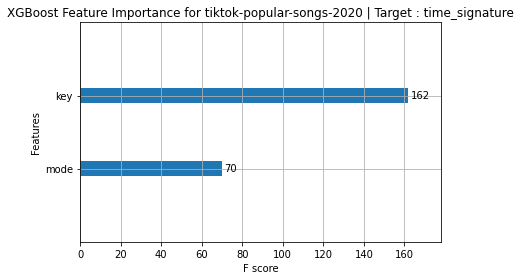

Target Variable: tempo
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


 14%|█▍        | 6/42 [00:00<00:00, 56.41it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.00798371624516181, 'Adjusted R-Squared': -0.047128299518995886, 'RMSE': 24.276223058803797, 'Time taken': 0.028319358825683594}
{'Model': 'BaggingRegressor', 'R-Squared': -0.037489697256249954, 'Adjusted R-Squared': -0.09512801377048619, 'RMSE': 24.82639237864053, 'Time taken': 0.030955791473388672}
{'Model': 'BayesianRidge', 'R-Squared': -0.0016513123098147453, 'Adjusted R-Squared': -0.05729860743813786, 'RMSE': 24.393830450937354, 'Time taken': 0.011111736297607422}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.019695220524469148, 'Adjusted R-Squared': -0.07634495499805083, 'RMSE': 24.61256695626, 'Time taken': 0.012694358825683594}
{'Model': 'DummyRegressor', 'R-Squared': -0.0016443491231621366, 'Adjusted R-Squared': -0.05729125740778218, 'RMSE': 24.393745, 'Time taken': 0.011040925979614258}
{'Model': 'ElasticNet', 'R-Squared': -0.003022723707281738, 'Adjusted R-Squared': -0.0587462083576864, 'RMSE': 24.41052415145329, 'Time taken'

 29%|██▊       | 12/42 [00:00<00:00, 32.32it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.016416798608365646, 'Adjusted R-Squared': -0.07288439853105255, 'RMSE': 24.572969173181384, 'Time taken': 0.11095166206359863}
{'Model': 'GammaRegressor', 'R-Squared': -0.008596768204737204, 'Adjusted R-Squared': -0.06462992199388928, 'RMSE': 24.478257828314195, 'Time taken': 0.011009931564331055}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.06418118303935505, 'Adjusted R-Squared': -0.12330235987487481, 'RMSE': 25.143718536649466, 'Time taken': 0.02459263801574707}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.008624378679800149, 'Adjusted R-Squared': -0.06465906638423347, 'RMSE': 24.47859287385633, 'Time taken': 0.015254974365234375}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.012157038831171585, 'Adjusted R-Squared': -0.06838798543290348, 'RMSE': 24.52142297268595, 'Time taken': 0.09496712684631348}


 38%|███▊      | 16/42 [00:00<00:01, 24.12it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.04215838417005835, 'Adjusted R-Squared': -0.10005607217950607, 'RMSE': 24.882188861038234, 'Time taken': 0.11734414100646973}
{'Model': 'HuberRegressor', 'R-Squared': -0.016200432393631337, 'Adjusted R-Squared': -0.07265601197105531, 'RMSE': 24.570353591016207, 'Time taken': 0.014751195907592773}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.1043379703824725, 'Adjusted R-Squared': -0.16569007984816553, 'RMSE': 25.613724, 'Time taken': 0.011657953262329102}
{'Model': 'KernelRidge', 'R-Squared': -24.486350571044554, 'Adjusted R-Squared': -25.902258936102584, 'RMSE': 123.04827934088522, 'Time taken': 0.012891769409179688}
{'Model': 'Lars', 'R-Squared': -0.019708186952806406, 'Adjusted R-Squared': -0.07635864178351781, 'RMSE': 24.612723442269097, 'Time taken': 0.012972831726074219}
{'Model': 'LarsCV', 'R-Squared': -0.001644352073139732, 'Adjusted R-Squared': -0.05729126052164757, 'RMSE': 24.393745697327883, 'Time taken': 0.01900

 50%|█████     | 21/42 [00:00<00:00, 25.44it/s]

{'Model': 'LassoCV', 'R-Squared': -0.001644352073139732, 'Adjusted R-Squared': -0.05729126052164757, 'RMSE': 24.393745697327883, 'Time taken': 0.09539246559143066}
{'Model': 'LassoLars', 'R-Squared': -0.001644352073139732, 'Adjusted R-Squared': -0.05729126052164757, 'RMSE': 24.393745697327883, 'Time taken': 0.010303974151611328}
{'Model': 'LassoLarsCV', 'R-Squared': -0.001644352073139732, 'Adjusted R-Squared': -0.05729126052164757, 'RMSE': 24.393745697327883, 'Time taken': 0.016620159149169922}
{'Model': 'LassoLarsIC', 'R-Squared': -0.001644352073139732, 'Adjusted R-Squared': -0.05729126052164757, 'RMSE': 24.393745697327883, 'Time taken': 0.010559320449829102}
{'Model': 'LinearRegression', 'R-Squared': -0.019708186952806406, 'Adjusted R-Squared': -0.07635864178351781, 'RMSE': 24.6127234422691, 'Time taken': 0.00951242446899414}
{'Model': 'LinearSVR', 'R-Squared': -0.6061744647181064, 'Adjusted R-Squared': -0.6954063794246679, 'RMSE': 30.8900120217243, 'Time taken': 0.009735107421875}


 79%|███████▊  | 33/42 [00:01<00:00, 18.17it/s]

{'Model': 'MLPRegressor', 'R-Squared': -12.940888873475878, 'Adjusted R-Squared': -13.715382699780093, 'RMSE': 91.00535569061148, 'Time taken': 0.6995184421539307}
{'Model': 'NuSVR', 'R-Squared': -0.03946462084328606, 'Adjusted R-Squared': -0.09721265533457979, 'RMSE': 24.850010404539525, 'Time taken': 0.020758867263793945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0077166329040099235, 'Adjusted R-Squared': -0.04741022082354518, 'RMSE': 24.2794908168632, 'Time taken': 0.013600587844848633}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0077166329040099235, 'Adjusted R-Squared': -0.04741022082354518, 'RMSE': 24.2794908168632, 'Time taken': 0.020071983337402344}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.016848171470509876, 'Adjusted R-Squared': -0.037771374558906334, 'RMSE': 24.167515978291952, 'Time taken': 0.014197111129760742}
{'Model': 'PoissonRegressor', 'R-Squared': -0.019337790726216886, 'Adjusted R-Squared': -0.07596766798878463, 'RMSE': 24.60825

100%|██████████| 42/42 [00:01<00:00, 21.77it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.029227577908361946, 'Adjusted R-Squared': -0.08640688779215977, 'RMSE': 24.727341457690578, 'Time taken': 0.14819860458374023}
{'Model': 'Ridge', 'R-Squared': -0.019591355425533585, 'Adjusted R-Squared': -0.07623531961584096, 'RMSE': 24.61131341905028, 'Time taken': 0.009523630142211914}
{'Model': 'RidgeCV', 'R-Squared': -0.01860143897976818, 'Adjusted R-Squared': -0.07519040781197761, 'RMSE': 24.59936301354537, 'Time taken': 0.00880289077758789}
{'Model': 'SGDRegressor', 'R-Squared': -0.01823043888737841, 'Adjusted R-Squared': -0.07479879660334388, 'RMSE': 24.594882754257746, 'Time taken': 0.011049509048461914}
{'Model': 'SVR', 'R-Squared': 0.010940173488936944, 'Adjusted R-Squared': -0.04400759465056647, 'RMSE': 24.24002145058712, 'Time taken': 0.011940479278564453}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.019708186952806406, 'Adjusted R-Squared': -0.07635864178351781, 'RMSE': 24.6127234422691, 'Time taken': 0.00887989

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,15511.013672,15050.255859,122.679482,00:00
1,15119.073242,14485.011719,120.353691,00:00
2,14032.360352,12243.646484,110.651009,00:00
3,12495.490234,5706.354980,75.540421,00:00
4,10267.443359,879.913269,29.663332,00:00
5,8601.460938,1387.171631,37.244755,00:00


Better model found at epoch 0 with _rmse value: 122.67948150634766.
Better model found at epoch 1 with _rmse value: 120.35369110107422.
Better model found at epoch 2 with _rmse value: 110.65100860595703.
Better model found at epoch 3 with _rmse value: 75.54042053222656.
Better model found at epoch 4 with _rmse value: 29.663331985473633.
No improvement since epoch 4: early stopping


,mode,key,time_signature,tempo,tempo_pred
0,2.00,2.00,3.00,131.12,165.12
1,1.00,11.00,3.00,105.00,80.81
2,2.00,8.00,3.00,114.97,127.20
3,1.00,8.00,3.00,126.75,105.87
4,2.00,2.00,3.00,112.46,165.12
5,2.00,10.00,3.00,106.74,83.92
6,2.00,6.00,3.00,162.95,124.60
7,2.00,11.00,3.00,119.94,76.44
8,2.00,8.00,3.00,139.94,127.20


<Figure size 432x288 with 0 Axes>

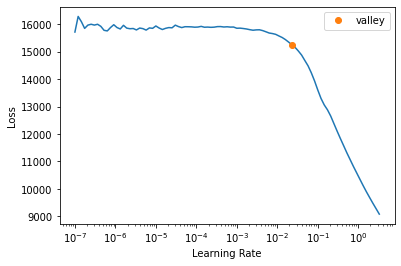

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   75.02     117.28
1  131.12     134.22
2  112.46     134.22
3  101.00     112.51
4  145.06     116.54
XGBoost RMSE:  24.612606


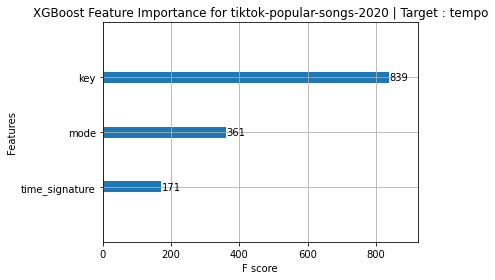

Target Variable: valence
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


 14%|█▍        | 6/42 [00:00<00:00, 59.02it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.05687714393502996, 'Adjusted R-Squared': -0.11559254082030934, 'RMSE': 0.25402767650846475, 'Time taken': 0.03678154945373535}
{'Model': 'BaggingRegressor', 'R-Squared': -0.1826204046136859, 'Adjusted R-Squared': -0.24832153820333525, 'RMSE': 0.26871472586753703, 'Time taken': 0.02838134765625}
{'Model': 'BayesianRidge', 'R-Squared': -0.03880943625314637, 'Adjusted R-Squared': -0.09652107160054335, 'RMSE': 0.2518469675406122, 'Time taken': 0.009818792343139648}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.1871733926180872, 'Adjusted R-Squared': -0.25312746998575864, 'RMSE': 0.26923149339101615, 'Time taken': 0.009122371673583984}
{'Model': 'DummyRegressor', 'R-Squared': -0.007588408676840963, 'Adjusted R-Squared': -0.06356554249222102, 'RMSE': 0.24803351, 'Time taken': 0.008282661437988281}
{'Model': 'ElasticNet', 'R-Squared': -0.0075884191960449154, 'Adjusted R-Squared': -0.06356555359582527, 'RMSE': 0.24803351423721015, 'Time taken

 29%|██▊       | 12/42 [00:00<00:00, 31.57it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.18717339261808674, 'Adjusted R-Squared': -0.2531274699857582, 'RMSE': 0.2692314933910161, 'Time taken': 0.11179590225219727}
{'Model': 'GammaRegressor', 'R-Squared': -0.02557251589064191, 'Adjusted R-Squared': -0.08254876677345546, 'RMSE': 0.2502372564127134, 'Time taken': 0.011116981506347656}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.17811257901869526, 'Adjusted R-Squared': -0.2435632778530672, 'RMSE': 0.2682021033794591, 'Time taken': 0.026599884033203125}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.02579788334682087, 'Adjusted R-Squared': -0.08278665464386648, 'RMSE': 0.25026474946425087, 'Time taken': 0.028309345245361328}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.14857485243827018, 'Adjusted R-Squared': -0.2123845664626185, 'RMSE': 0.26481856911331775, 'Time taken': 0.09588837623596191}


 38%|███▊      | 16/42 [00:00<00:01, 24.22it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.13896120724177163, 'Adjusted R-Squared': -0.20223682986631464, 'RMSE': 0.26370796606941194, 'Time taken': 0.10788226127624512}
{'Model': 'HuberRegressor', 'R-Squared': -0.05484088371785001, 'Adjusted R-Squared': -0.11344315503550839, 'RMSE': 0.2537828439627544, 'Time taken': 0.01442265510559082}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.23950895565723562, 'Adjusted R-Squared': -0.30837056430485976, 'RMSE': 0.27510193, 'Time taken': 0.010808467864990234}
{'Model': 'KernelRidge', 'R-Squared': -4.526151403312932, 'Adjusted R-Squared': -4.833159814608095, 'RMSE': 0.5808716390293559, 'Time taken': 0.027290821075439453}
{'Model': 'Lars', 'R-Squared': -0.048879140951445965, 'Adjusted R-Squared': -0.10715020433763733, 'RMSE': 0.25306466366934405, 'Time taken': 0.025325775146484375}


 45%|████▌     | 19/42 [00:00<00:00, 25.26it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0045707028857677745, 'Adjusted R-Squared': -0.06038018637942155, 'RMSE': 0.2476618068806237, 'Time taken': 0.04801630973815918}
{'Model': 'Lasso', 'R-Squared': -0.0075884191960449154, 'Adjusted R-Squared': -0.06356555359582527, 'RMSE': 0.24803351423721015, 'Time taken': 0.01886153221130371}


 52%|█████▏    | 22/42 [00:00<00:00, 25.67it/s]

{'Model': 'LassoCV', 'R-Squared': -0.005690075323301791, 'Adjusted R-Squared': -0.06156174617459631, 'RMSE': 0.2477997506888109, 'Time taken': 0.07831811904907227}
{'Model': 'LassoLars', 'R-Squared': -0.0075884191960449154, 'Adjusted R-Squared': -0.06356555359582527, 'RMSE': 0.24803351423721015, 'Time taken': 0.009800910949707031}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0045707028857677745, 'Adjusted R-Squared': -0.06038018637942155, 'RMSE': 0.2476618068806237, 'Time taken': 0.01719975471496582}
{'Model': 'LassoLarsIC', 'R-Squared': -0.03849536421529964, 'Adjusted R-Squared': -0.09618955111614969, 'RMSE': 0.25180889315128585, 'Time taken': 0.010596036911010742}
{'Model': 'LinearRegression', 'R-Squared': -0.048879140951445965, 'Adjusted R-Squared': -0.10715020433763733, 'RMSE': 0.25306466366934405, 'Time taken': 0.00948953628540039}
{'Model': 'LinearSVR', 'R-Squared': -0.1017558988125371, 'Adjusted R-Squared': -0.1629645598576781, 'RMSE': 0.25936506288490024, 'Time taken': 0.0115485191

 71%|███████▏  | 30/42 [00:01<00:00, 25.01it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.06064955343144485, 'Adjusted R-Squared': -0.11957452862208062, 'RMSE': 0.2544806349310305, 'Time taken': 0.1570444107055664}
{'Model': 'NuSVR', 'R-Squared': -0.09267436010051, 'Adjusted R-Squared': -0.15337849121720493, 'RMSE': 0.2582939055602441, 'Time taken': 0.032242774963378906}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.005907255886298035, 'Adjusted R-Squared': -0.06179099232442575, 'RMSE': 0.24782650564320202, 'Time taken': 0.03414773941040039}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.005907255886298035, 'Adjusted R-Squared': -0.06179099232442575, 'RMSE': 0.24782650564320202, 'Time taken': 0.044246673583984375}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.2699316608369564, 'Adjusted R-Squared': -0.340483419772343, 'RMSE': 0.2784575247654531, 'Time taken': 0.009411334991455078}
{'Model': 'PoissonRegressor', 'R-Squared': -0.020203516905902053, 'Adjusted R-Squared': -0.07688149006734113, 'RMSE': 0.24958

100%|██████████| 42/42 [00:01<00:00, 28.54it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.15461976403909805, 'Adjusted R-Squared': -0.21876530648571468, 'RMSE': 0.26551452032440287, 'Time taken': 0.14819002151489258}
{'Model': 'Ridge', 'R-Squared': -0.04866242351131245, 'Adjusted R-Squared': -0.10692144703971862, 'RMSE': 0.2530385184457589, 'Time taken': 0.011440038681030273}
{'Model': 'RidgeCV', 'R-Squared': -0.046808418224812076, 'Adjusted R-Squared': -0.10496444145952388, 'RMSE': 0.2528147370466723, 'Time taken': 0.00902414321899414}
{'Model': 'SGDRegressor', 'R-Squared': -0.04286371734951566, 'Adjusted R-Squared': -0.10080059053559998, 'RMSE': 0.252337945025471, 'Time taken': 0.010381460189819336}
{'Model': 'SVR', 'R-Squared': -0.1343071862658547, 'Adjusted R-Squared': -0.19732425216951333, 'RMSE': 0.2631686330719233, 'Time taken': 0.012728214263916016}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.048879140951445965, 'Adjusted R-Squared': -0.10715020433763733, 'RMSE': 0.25306466366934405, 'Time taken': 0.0093

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,7.925165,0.061899,0.248794,00:00
1,5.751885,0.109054,0.330234,00:00


Better model found at epoch 0 with _rmse value: 0.24879418313503265.
No improvement since epoch 0: early stopping


,mode,key,time_signature,valence,valence_pred
0,2.00,10.00,3.00,0.25,0.55
1,1.00,7.00,3.00,0.63,0.58
2,1.00,8.00,3.00,0.54,0.57
3,2.00,1.00,3.00,0.78,0.51
4,2.00,1.00,3.00,0.49,0.51
5,2.00,9.00,3.00,0.73,0.53
6,1.00,9.00,3.00,0.78,0.51
7,1.00,7.00,3.00,0.87,0.58
8,1.00,5.00,3.00,0.89,0.53


<Figure size 432x288 with 0 Axes>

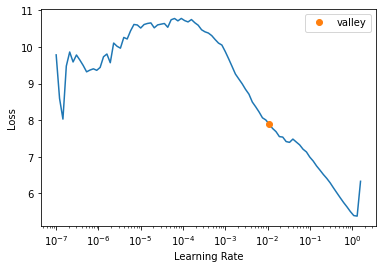

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.42       0.54
1    0.21       0.53
2    0.20       0.64
3    0.07       0.56
4    0.77       0.57
XGBoost RMSE:  0.26716143


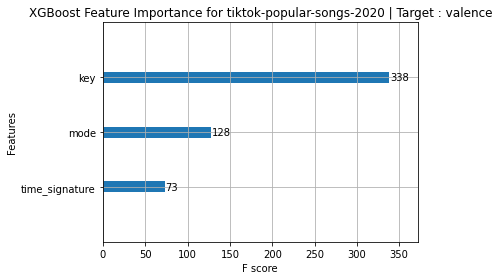

Target Variable: liveness
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.05978385339169434, 'Adjusted R-Squared': -0.11866073413567735, 'RMSE': 0.15813353603619054, 'Time taken': 0.020720243453979492}
{'Model': 'BaggingRegressor', 'R-Squared': -0.12151831075036368, 'Adjusted R-Squared': -0.1838248835698284, 'RMSE': 0.1626741392391251, 'Time taken': 0.027091026306152344}
{'Model': 'BayesianRidge', 'R-Squared': 0.0010460748555076727, 'Adjusted R-Squared': -0.05445136543029738, 'RMSE': 0.15352816598555194, 'Time taken': 0.009380817413330078}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.15502571580740643, 'Adjusted R-Squared': -0.21919381113004022, 'RMSE': 0.16508634786186982, 'Time taken': 0.009005308151245117}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011911953433278999, 'Adjusted R-Squared': -0.056812928417957265, 'RMSE': 0.1537, 'Time taken': 0.008345842361450195}
{'Model': 'ElasticNet', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time 

 17%|█▋        | 7/42 [00:00<00:00, 48.07it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.06155109405517578}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.12939850573899414, 'Adjusted R-Squared': -0.19214286716893825, 'RMSE': 0.1632446426451895, 'Time taken': 0.011858224868774414}


 29%|██▊       | 12/42 [00:00<00:00, 36.09it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.12361359268134153, 'Adjusted R-Squared': -0.18603657005252727, 'RMSE': 0.16282602669920737, 'Time taken': 0.11235857009887695}
{'Model': 'GammaRegressor', 'R-Squared': 0.008310424712404507, 'Adjusted R-Squared': -0.046783440581350755, 'RMSE': 0.15296892233097448, 'Time taken': 0.01102757453918457}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.16414798238764394, 'Adjusted R-Squared': -0.22882287029806858, 'RMSE': 0.16573698267361797, 'Time taken': 0.021519899368286133}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.007738374310602203, 'Adjusted R-Squared': -0.047387271561031064, 'RMSE': 0.1530130355897897, 'Time taken': 0.014241218566894531}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.09091339835886392, 'Adjusted R-Squared': -0.15151969826768963, 'RMSE': 0.1604391937879716, 'Time taken': 0.09259438514709473}


 38%|███▊      | 16/42 [00:00<00:01, 25.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.0010249121131944428, 'Adjusted R-Squared': -0.05663740723059418, 'RMSE': 0.15368722748039257, 'Time taken': 0.11586523056030273}
{'Model': 'HuberRegressor', 'R-Squared': -0.030129620113428457, 'Adjusted R-Squared': -0.08735904345306333, 'RMSE': 0.15590544047913726, 'Time taken': 0.015230894088745117}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.08215725904585325, 'Adjusted R-Squared': -0.142277106770623, 'RMSE': 0.15979403, 'Time taken': 0.011153221130371094}
{'Model': 'KernelRidge', 'R-Squared': -1.5385312071004114, 'Adjusted R-Squared': -1.6795607186059898, 'RMSE': 0.24474091900321968, 'Time taken': 0.013383626937866211}
{'Model': 'Lars', 'R-Squared': 0.016068348619044492, 'Adjusted R-Squared': -0.03859452090211968, 'RMSE': 0.1523694145197506, 'Time taken': 0.018865346908569336}


 48%|████▊     | 20/42 [00:00<00:00, 28.32it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.04676103591918945}
{'Model': 'Lasso', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.02730083465576172}


 57%|█████▋    | 24/42 [00:00<00:00, 29.39it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.07957100868225098}
{'Model': 'LassoLars', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.010421991348266602}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.017256498336791992}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0011912136949143726, 'Adjusted R-Squared': -0.05681294778907642, 'RMSE': 0.15369999308057153, 'Time taken': 0.011033773422241211}
{'Model': 'LinearRegression', 'R-Squared': 0.016068348619044492, 'Adjusted R-Squared': -0.03859452090211968, 'RMSE': 0.1523694145197506, 'Time taken': 0.010568618774414062}
{'Model': 'LinearSVR', 'R-Squared': -0.1096029960586431, 'Adjusted R-Squared': -0.17124760695079, 'RMSE': 0.1618076846452799, 'Time taken': 0.01450419

 79%|███████▊  | 33/42 [00:01<00:00, 29.82it/s]

{'Model': 'NuSVR', 'R-Squared': -0.0012886850175133358, 'Adjusted R-Squared': -0.056915834185153, 'RMSE': 0.1537074746569145, 'Time taken': 0.055939674377441406}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0024784070514274337, 'Adjusted R-Squared': -0.05817165188761786, 'RMSE': 0.15379876445349985, 'Time taken': 0.02972412109375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.016068348619044492, 'Adjusted R-Squared': -0.03859452090211968, 'RMSE': 0.1523694145197506, 'Time taken': 0.015929460525512695}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.34784150263532143, 'Adjusted R-Squared': -0.4227215861150615, 'RMSE': 0.1783342442411118, 'Time taken': 0.011098623275756836}
{'Model': 'PoissonRegressor', 'R-Squared': 0.001607665016435722, 'Adjusted R-Squared': -0.05385857581598463, 'RMSE': 0.15348500482144883, 'Time taken': 0.010253667831420898}
{'Model': 'RANSACRegressor', 'R-Squared': -0.3436272239828315, 'Adjusted R-Squared': -0.4182731808707667, 'RMSE': 0.1

100%|██████████| 42/42 [00:01<00:00, 30.20it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.12421565612961838, 'Adjusted R-Squared': -0.1866720814701528, 'RMSE': 0.16286964421649455, 'Time taken': 0.15258479118347168}
{'Model': 'Ridge', 'R-Squared': 0.016001474983094788, 'Adjusted R-Squared': -0.03866510974006654, 'RMSE': 0.15237459238124834, 'Time taken': 0.009139776229858398}
{'Model': 'RidgeCV', 'R-Squared': 0.015420271683763032, 'Adjusted R-Squared': -0.039278602111583405, 'RMSE': 0.15241958611866308, 'Time taken': 0.009389638900756836}
{'Model': 'SGDRegressor', 'R-Squared': 0.013390131888837642, 'Adjusted R-Squared': -0.04142152745067129, 'RMSE': 0.15257664486916234, 'Time taken': 0.009323596954345703}
{'Model': 'SVR', 'R-Squared': 0.008355745765131428, 'Adjusted R-Squared': -0.04673560169236124, 'RMSE': 0.15296542688644382, 'Time taken': 0.016347646713256836}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.016068348619044492, 'Adjusted R-Squared': -0.03859452090211968, 'RMSE': 0.1523694145197506, 'Time taken': 0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3.923521,0.199463,0.446613,00:00
1,2.905732,0.102471,0.320111,00:00
2,3.092637,0.166758,0.408360,00:00


Better model found at epoch 0 with _rmse value: 0.446613073348999.
Better model found at epoch 1 with _rmse value: 0.3201112747192383.
No improvement since epoch 1: early stopping


,mode,key,time_signature,liveness,liveness_pred
0,2.00,2.00,3.00,0.05,-0.07
1,2.00,1.00,3.00,0.12,-0.05
2,2.00,2.00,3.00,0.26,-0.07
3,2.00,3.00,3.00,0.18,-0.03
4,2.00,6.00,2.00,0.32,0.04
5,1.00,12.00,3.00,0.12,-0.02
6,2.00,2.00,2.00,0.35,0.08
7,1.00,12.00,3.00,0.25,-0.02
8,2.00,10.00,3.00,0.41,-0.22


<Figure size 432x288 with 0 Axes>

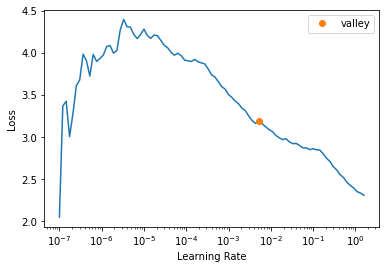

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.21       0.13
1    0.10       0.16
2    0.08       0.29
3    0.60       0.17
4    0.48       0.21
XGBoost RMSE:  0.16268583


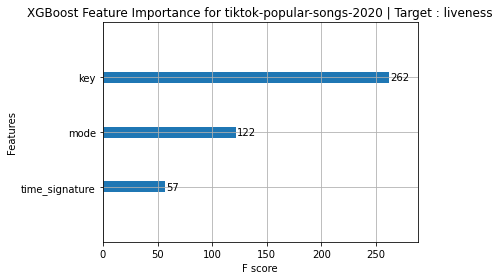

Target Variable: instrumentalness
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.20988330060802762, 'Adjusted R-Squared': -0.2770990395306958, 'RMSE': 0.15322017490845485, 'Time taken': 0.02013397216796875}
{'Model': 'BaggingRegressor', 'R-Squared': -0.5500534114886861, 'Adjusted R-Squared': -0.6361674899047243, 'RMSE': 0.17342733248819076, 'Time taken': 0.027562856674194336}
{'Model': 'BayesianRidge', 'R-Squared': -0.07829146549367128, 'Adjusted R-Squared': -0.1381965469099864, 'RMSE': 0.1446479544718291, 'Time taken': 0.009313821792602539}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.27344042806011126, 'Adjusted R-Squared': -0.3441871185078953, 'RMSE': 0.15719311827489835, 'Time taken': 0.009033203125}
{'Model': 'DummyRegressor', 'R-Squared': -0.014429180743574577, 'Adjusted R-Squared': -0.07078635745155104, 'RMSE': 0.14029916, 'Time taken': 0.008346796035766602}
{'Model': 'ElasticNet', 'R-Squared': -0.014429263637486756, 'Adjusted R-Squared': -0.07078644495068054, 'RMSE': 0.14029916847173562, 'Time taken': 0.0

 17%|█▋        | 7/42 [00:00<00:00, 48.95it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.08305880731909832, 'Adjusted R-Squared': -0.14322874105904826, 'RMSE': 0.14496736056286544, 'Time taken': 0.058725595474243164}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.27344042806011126, 'Adjusted R-Squared': -0.3441871185078953, 'RMSE': 0.15719311827489835, 'Time taken': 0.009974956512451172}


 29%|██▊       | 12/42 [00:00<00:00, 37.20it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.27344042806011193, 'Adjusted R-Squared': -0.34418711850789596, 'RMSE': 0.1571931182748984, 'Time taken': 0.11056947708129883}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.25447864893802263, 'Adjusted R-Squared': -0.3241719072123572, 'RMSE': 0.15601841070094835, 'Time taken': 0.02344369888305664}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.04977029075233097, 'Adjusted R-Squared': -0.10809086246079391, 'RMSE': 0.14272214081315762, 'Time taken': 0.014343738555908203}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.24265455557631066, 'Adjusted R-Squared': -0.31169091977499463, 'RMSE': 0.15528139383341344, 'Time taken': 0.06917381286621094}


 38%|███▊      | 16/42 [00:00<00:00, 26.55it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.27836557809409124, 'Adjusted R-Squared': -0.34938588798820747, 'RMSE': 0.157496804472708, 'Time taken': 0.1173255443572998}
{'Model': 'HuberRegressor', 'R-Squared': -0.09142920138352806, 'Adjusted R-Squared': -0.15206415701594622, 'RMSE': 0.14552647076242456, 'Time taken': 0.025168895721435547}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.8096634309450788, 'Adjusted R-Squared': -0.9102002882198055, 'RMSE': 0.18738858, 'Time taken': 0.011042118072509766}
{'Model': 'KernelRidge', 'R-Squared': -0.17034919278898797, 'Adjusted R-Squared': -0.23536859238837615, 'RMSE': 0.15069607555863956, 'Time taken': 0.014450788497924805}
{'Model': 'Lars', 'R-Squared': -0.09700811938233134, 'Adjusted R-Squared': -0.15795301490357194, 'RMSE': 0.14589793113442057, 'Time taken': 0.013435125350952148}


 48%|████▊     | 20/42 [00:00<00:00, 29.12it/s]

{'Model': 'LarsCV', 'R-Squared': -0.07547200766268358, 'Adjusted R-Squared': -0.13522045253283266, 'RMSE': 0.144458721893125, 'Time taken': 0.044156789779663086}
{'Model': 'Lasso', 'R-Squared': -0.014429263637486756, 'Adjusted R-Squared': -0.07078644495068054, 'RMSE': 0.14029916847173562, 'Time taken': 0.034212350845336914}


 57%|█████▋    | 24/42 [00:00<00:00, 29.97it/s]

{'Model': 'LassoCV', 'R-Squared': -0.08410739945529833, 'Adjusted R-Squared': -0.14433558831392612, 'RMSE': 0.1450375205844361, 'Time taken': 0.07484054565429688}
{'Model': 'LassoLars', 'R-Squared': -0.014429263637486756, 'Adjusted R-Squared': -0.07078644495068054, 'RMSE': 0.14029916847173562, 'Time taken': 0.01017141342163086}
{'Model': 'LassoLarsCV', 'R-Squared': -0.07547200766268358, 'Adjusted R-Squared': -0.13522045253283266, 'RMSE': 0.144458721893125, 'Time taken': 0.017189979553222656}
{'Model': 'LassoLarsIC', 'R-Squared': -0.05851700678864069, 'Adjusted R-Squared': -0.11732350716578743, 'RMSE': 0.14331548990277, 'Time taken': 0.010496377944946289}
{'Model': 'LinearRegression', 'R-Squared': -0.09700811938233089, 'Adjusted R-Squared': -0.1579530149035715, 'RMSE': 0.14589793113442054, 'Time taken': 0.009561777114868164}
{'Model': 'LinearSVR', 'R-Squared': -0.09118686073595339, 'Adjusted R-Squared': -0.15180835299906192, 'RMSE': 0.14551031353619123, 'Time taken': 0.02051806449890136

 67%|██████▋   | 28/42 [00:01<00:00, 18.40it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.20276779057023964, 'Adjusted R-Squared': -0.26958822337969734, 'RMSE': 0.15276895478253977, 'Time taken': 0.2532503604888916}
{'Model': 'NuSVR', 'R-Squared': -0.09134564104692533, 'Adjusted R-Squared': -0.15197595443842116, 'RMSE': 0.14552089986803055, 'Time taken': 0.1037743091583252}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.03210333449616187, 'Adjusted R-Squared': -0.08944240863483754, 'RMSE': 0.1415160842501573, 'Time taken': 0.011501550674438477}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.07975030770486602, 'Adjusted R-Squared': -0.13973643591069185, 'RMSE': 0.1447457699623202, 'Time taken': 0.013354778289794922}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.12890170593636952, 'Adjusted R-Squared': -0.19161846737727894, 'RMSE': 0.14800359933009563, 'Time taken': 0.009594440460205078}
{'Model': 'PoissonRegressor', 'R-Squared': -0.015912832921843423, 'Adjusted R-Squared': -0.07235243475083486, 'RMSE': 0.1

 81%|████████  | 34/42 [00:01<00:00, 20.40it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
{'Model': 'RandomForestRegressor', 'R-Squared': -0.2951607974417203, 'Adjusted R-Squared': -0.36711417507737143, 'RMSE': 0.15852802819558637, 'Time taken': 0.14735126495361328}
{'Model': 'Ridge', 'R-Squared': -0.09655309613535978, 'Adjusted R-Squared': -0.15747271258732431, 'RMSE': 0.1458676698106003, 'Time taken': 0.009937524795532227}
{'Model': 'RidgeCV', 'R-Squared': -0.09266705286804311, 'Adjusted R-Squared': -0.15337077802737897, 'RMSE': 0.14560897227044914, 'Time taken': 0.00898289680480957}
{'Model': 'SGDRegressor', 'R-Squared': -0.09285623746640925, 'Adjusted R-Squared': -0.15357047288120973, 'RMSE': 0.14562157710858173, 'Time taken': 0.009148597717285156}
{'Model': 'SVR', 'R-Squared': -0.17095159974421215, 'Adjusted R-Squared': -0.23

100%|██████████| 42/42 [00:01<00:00, 27.40it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.2681701947098889, 'Adjusted R-Squared': -0.33862409441599395, 'RMSE': 0.1568675, 'Time taken': 0.027401447296142578}
{'Model': 'LGBMRegressor', 'R-Squared': -0.27836557809409124, 'Adjusted R-Squared': -0.34938588798820747, 'RMSE': 0.157496804472708, 'Time taken': 0.031025409698486328}
Project: tiktok-popular-songs-2020
tiktok-popular-songs-2020
Target: instrumentalness
instrumentalness
Target Standard Deviation: 0.10648360848426819
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DummyRegressor                              -0.07      -0.01  0.14        0.01
LassoLars                                   -0.07      -0.01  0.14        0.01
Lasso                                       -0.07      -0.01  0.14        0.03
ElasticNet                                  -0.07      -0.01  0.14        0.01
PoissonRegressor                            -0.0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3.857283,0.169080,0.411193,00:00
1,3.793473,0.032972,0.181582,00:00
2,4.053225,0.032859,0.181269,00:00
3,4.936069,0.243076,0.493027,00:00


Better model found at epoch 0 with _rmse value: 0.4111928939819336.
Better model found at epoch 1 with _rmse value: 0.1815817505121231.
Better model found at epoch 2 with _rmse value: 0.18126915395259857.
No improvement since epoch 2: early stopping


,mode,key,time_signature,instrumentalness,instrumentalness_pred
0,1.00,12.00,3.00,0.00,0.11
1,1.00,12.00,3.00,0.07,0.11
2,2.00,10.00,3.00,0.00,0.00
3,2.00,6.00,3.00,0.00,0.09
4,1.00,2.00,3.00,0.00,0.16
5,2.00,12.00,3.00,0.00,-0.13
6,2.00,2.00,3.00,0.00,-0.07
7,2.00,2.00,3.00,0.00,-0.07
8,1.00,11.00,3.00,0.00,0.20


<Figure size 432x288 with 0 Axes>

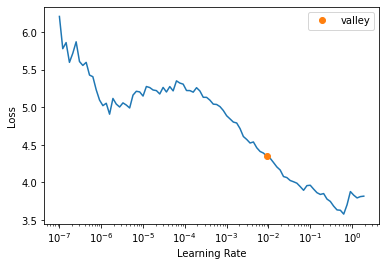

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1    0.00       0.02
2    0.00       0.00
3    0.69       0.00
4    0.00       0.03
XGBoost RMSE:  0.1568675


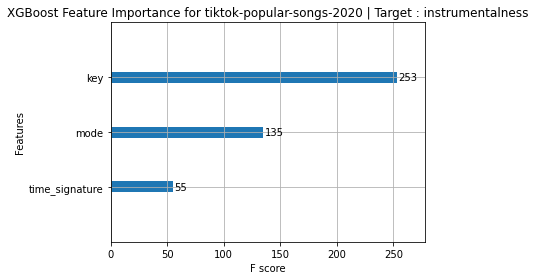

Target Variable: acousticness
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.10458273690753672, 'Adjusted R-Squared': -0.1659484445135111, 'RMSE': 0.23056983359847438, 'Time taken': 0.024581193923950195}
{'Model': 'BaggingRegressor', 'R-Squared': -0.13092921717233774, 'Adjusted R-Squared': -0.19375861812635664, 'RMSE': 0.23330340239980502, 'Time taken': 0.026453256607055664}
{'Model': 'BayesianRidge', 'R-Squared': 0.08887977533587421, 'Adjusted R-Squared': 0.038261985076756044, 'RMSE': 0.20940700425792558, 'Time taken': 0.008985042572021484}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.19376753517468148, 'Adjusted R-Squared': -0.2600879537954972, 'RMSE': 0.23969735534723216, 'Time taken': 0.008626461029052734}
{'Model': 'DummyRegressor', 'R-Squared': -0.04187830570925688, 'Adjusted R-Squared': -0.09976043380421573, 'RMSE': 0.22392978, 'Time taken': 0.008132457733154297}
{'Model': 'ElasticNet', 'R-Squared': -0.04187829319292802, 'Adjusted R-Squared': -0.09976042059253509, 'RMSE': 0.2239297809813333, 'Time take

 17%|█▋        | 7/42 [00:00<00:00, 49.00it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.1085519750449806, 'Adjusted R-Squared': 0.059027084769701754, 'RMSE': 0.20713399138857852, 'Time taken': 0.0565342903137207}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.19376753517468148, 'Adjusted R-Squared': -0.2600879537954972, 'RMSE': 0.23969735534723216, 'Time taken': 0.010162115097045898}


 29%|██▊       | 12/42 [00:00<00:00, 37.19it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.19376753517468215, 'Adjusted R-Squared': -0.2600879537954979, 'RMSE': 0.23969735534723222, 'Time taken': 0.11246776580810547}
{'Model': 'GammaRegressor', 'R-Squared': 0.03960759927498669, 'Adjusted R-Squared': -0.01374753409862528, 'RMSE': 0.21499468214937037, 'Time taken': 0.01149606704711914}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.0851714944273394, 'Adjusted R-Squared': -0.14545879967330277, 'RMSE': 0.2285349092129825, 'Time taken': 0.01688671112060547}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.04647860835195439, 'Adjusted R-Squared': -0.006494802295159197, 'RMSE': 0.21422422516159867, 'Time taken': 0.013842105865478516}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.09513324197217188, 'Adjusted R-Squared': 0.04486286652618143, 'RMSE': 0.20868713524782856, 'Time taken': 0.1101384162902832}


 38%|███▊      | 16/42 [00:00<00:01, 24.11it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.034637467464429306, 'Adjusted R-Squared': -0.018993784343102504, 'RMSE': 0.2155502743253184, 'Time taken': 0.13027548789978027}
{'Model': 'HuberRegressor', 'R-Squared': 0.13117627486631656, 'Adjusted R-Squared': 0.08290829013666745, 'RMSE': 0.20448864456731158, 'Time taken': 0.01455545425415039}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.1320739971508451, 'Adjusted R-Squared': -0.1949669969925587, 'RMSE': 0.23342144, 'Time taken': 0.010569334030151367}
{'Model': 'KernelRidge', 'R-Squared': -0.6649658965297844, 'Adjusted R-Squared': -0.7574640018925503, 'RMSE': 0.2830779432598987, 'Time taken': 0.0251314640045166}


 48%|████▊     | 20/42 [00:00<00:00, 26.61it/s]

{'Model': 'Lars', 'R-Squared': 0.11610351499854721, 'Adjusted R-Squared': 0.06699815472068871, 'RMSE': 0.20625479975128166, 'Time taken': 0.03052234649658203}
{'Model': 'LarsCV', 'R-Squared': 0.10784339653360087, 'Adjusted R-Squared': 0.05827914078546759, 'RMSE': 0.20721629654666143, 'Time taken': 0.03284406661987305}
{'Model': 'Lasso', 'R-Squared': -0.04187829319292802, 'Adjusted R-Squared': -0.09976042059253509, 'RMSE': 0.2239297809813333, 'Time taken': 0.025922298431396484}


 55%|█████▍    | 23/42 [00:00<00:00, 26.45it/s]

{'Model': 'LassoCV', 'R-Squared': 0.10895314798876532, 'Adjusted R-Squared': 0.059450545099252294, 'RMSE': 0.20708737851731718, 'Time taken': 0.07737469673156738}
{'Model': 'LassoLars', 'R-Squared': -0.04187829319292802, 'Adjusted R-Squared': -0.09976042059253509, 'RMSE': 0.2239297809813333, 'Time taken': 0.010140419006347656}
{'Model': 'LassoLarsCV', 'R-Squared': 0.10784339653360087, 'Adjusted R-Squared': 0.05827914078546759, 'RMSE': 0.20721629654666143, 'Time taken': 0.017408132553100586}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0678453500864935, 'Adjusted R-Squared': 0.016058980646854182, 'RMSE': 0.21181043178108339, 'Time taken': 0.011156082153320312}
{'Model': 'LinearRegression', 'R-Squared': 0.11610351499854765, 'Adjusted R-Squared': 0.06699815472068915, 'RMSE': 0.20625479975128158, 'Time taken': 0.009674549102783203}
{'Model': 'LinearSVR', 'R-Squared': 0.03296537924694887, 'Adjusted R-Squared': -0.020758766350442936, 'RMSE': 0.2157368690645449, 'Time taken': 0.01756882667541504}


 64%|██████▍   | 27/42 [00:01<00:00, 23.20it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.13011423287077406, 'Adjusted R-Squared': 0.08178724580803931, 'RMSE': 0.20461358889955117, 'Time taken': 0.17120957374572754}


 71%|███████▏  | 30/42 [00:01<00:00, 23.88it/s]

{'Model': 'NuSVR', 'R-Squared': 0.1386149479845531, 'Adjusted R-Squared': 0.09076022287258378, 'RMSE': 0.2036113699067471, 'Time taken': 0.04575920104980469}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.10779017517004108, 'Adjusted R-Squared': 0.05822296267948779, 'RMSE': 0.20722247717086073, 'Time taken': 0.0353851318359375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.10779017517004108, 'Adjusted R-Squared': 0.05822296267948779, 'RMSE': 0.20722247717086073, 'Time taken': 0.03086566925048828}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.3418983337547439, 'Adjusted R-Squared': -1.4720037967411188, 'RMSE': 0.33572785767557634, 'Time taken': 0.010935544967651367}
{'Model': 'PoissonRegressor', 'R-Squared': -0.0033919576792127426, 'Adjusted R-Squared': -0.05913595532805793, 'RMSE': 0.21975495095539319, 'Time taken': 0.010653018951416016}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4221374371587452, 'Adjusted R-Squared': -0.5011450725564532, 'RMSE': 0.2616219

100%|██████████| 42/42 [00:01<00:00, 28.39it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.13303548698675471, 'Adjusted R-Squared': -0.19598190293046325, 'RMSE': 0.23352055627675453, 'Time taken': 0.14991450309753418}
{'Model': 'Ridge', 'R-Squared': 0.11559084721770674, 'Adjusted R-Squared': 0.06645700539646815, 'RMSE': 0.20631460588477896, 'Time taken': 0.011772394180297852}
{'Model': 'RidgeCV', 'R-Squared': 0.11110844163879197, 'Adjusted R-Squared': 0.06172557728539152, 'RMSE': 0.20683677197526842, 'Time taken': 0.009839296340942383}
{'Model': 'SGDRegressor', 'R-Squared': 0.12326550490919497, 'Adjusted R-Squared': 0.07455803295970576, 'RMSE': 0.20541748489664532, 'Time taken': 0.0098114013671875}
{'Model': 'SVR', 'R-Squared': 0.15641698315715602, 'Adjusted R-Squared': 0.10955125999922022, 'RMSE': 0.20149639211712805, 'Time taken': 0.012313365936279297}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.11610351499854765, 'Adjusted R-Squared': 0.06699815472068915, 'RMSE': 0.20625479975128158, 'Time taken': 0.00930309295

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2.617911,0.117150,0.342272,00:00
1,3.746054,0.098110,0.313225,00:00
2,4.852156,0.093308,0.305464,00:00
3,7.129951,0.187305,0.432788,00:00


Better model found at epoch 0 with _rmse value: 0.34227195382118225.
Better model found at epoch 1 with _rmse value: 0.31322547793388367.
Better model found at epoch 2 with _rmse value: 0.3054637312889099.
No improvement since epoch 2: early stopping


,mode,key,time_signature,acousticness,acousticness_pred
0,2.00,12.00,3.00,0.31,0.14
1,2.00,4.00,3.00,0.27,0.21
2,2.00,10.00,3.00,0.33,0.31
3,2.00,11.00,3.00,0.22,0.25
4,1.00,6.00,3.00,0.28,0.45
5,2.00,8.00,3.00,0.00,0.47
6,2.00,8.00,3.00,0.38,0.47
7,2.00,2.00,3.00,0.03,0.20
8,1.00,5.00,3.00,0.03,0.52


<Figure size 432x288 with 0 Axes>

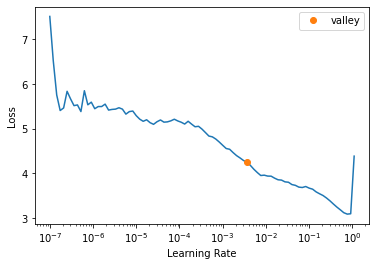

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.05       0.23
1    0.04       0.04
2    0.02       0.07
3    0.18       0.23
4    0.08       0.35
XGBoost RMSE:  0.23887011


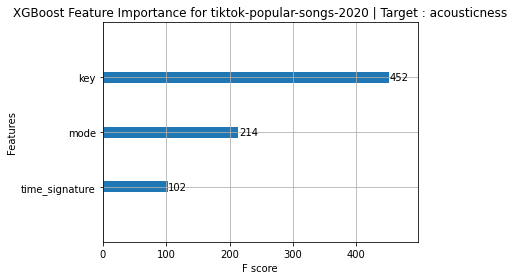

Target Variable: speechiness
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.008736319958252414, 'Adjusted R-Squared': -0.06477722662259988, 'RMSE': 0.19332927215498816, 'Time taken': 0.02468395233154297}
{'Model': 'BaggingRegressor', 'R-Squared': -0.04616989371962177, 'Adjusted R-Squared': -0.10429044337071192, 'RMSE': 0.19688376049957435, 'Time taken': 0.027777671813964844}
{'Model': 'BayesianRidge', 'R-Squared': -0.007557231638620987, 'Adjusted R-Squared': -0.0635326333963222, 'RMSE': 0.19321625008315726, 'Time taken': 0.009408712387084961}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.042163104121802464, 'Adjusted R-Squared': -0.1000610543507916, 'RMSE': 0.19650637027107432, 'Time taken': 0.008839130401611328}
{'Model': 'DummyRegressor', 'R-Squared': -0.006093809302119668, 'Adjusted R-Squared': -0.06198790981890423, 'RMSE': 0.19307588, 'Time taken': 0.008196592330932617}
{'Model': 'ElasticNet', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Tim

 17%|█▋        | 7/42 [00:00<00:00, 47.42it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.05912017822265625}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.002449115534431945, 'Adjusted R-Squared': -0.058140733064122596, 'RMSE': 0.19272584362001163, 'Time taken': 0.010734319686889648}


 29%|██▊       | 12/42 [00:00<00:00, 33.37it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.040541110057768615, 'Adjusted R-Squared': -0.09834894950542239, 'RMSE': 0.19635339216334574, 'Time taken': 0.11133360862731934}
{'Model': 'GammaRegressor', 'R-Squared': -0.011343482731143828, 'Adjusted R-Squared': -0.06752923177176307, 'RMSE': 0.19357894870951953, 'Time taken': 0.011801004409790039}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.2923043470568445, 'Adjusted R-Squared': -0.3640990330044469, 'RMSE': 0.2188221039910404, 'Time taken': 0.029392480850219727}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.01076045174081397, 'Adjusted R-Squared': -0.06691381017085929, 'RMSE': 0.1935231423495318, 'Time taken': 0.028533935546875}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.03193513589413477, 'Adjusted R-Squared': -0.02184624544508007, 'RMSE': 0.1893917320089483, 'Time taken': 0.09604668617248535}


 38%|███▊      | 16/42 [00:00<00:01, 24.43it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.01367549999297235, 'Adjusted R-Squared': -0.041120305562973636, 'RMSE': 0.19116954099087874, 'Time taken': 0.11358308792114258}
{'Model': 'HuberRegressor', 'R-Squared': -0.0702708458756176, 'Adjusted R-Squared': -0.12973033731315198, 'RMSE': 0.1991386848332558, 'Time taken': 0.014296770095825195}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.08428946573834639, 'Adjusted R-Squared': -0.14452776939047673, 'RMSE': 0.20043862, 'Time taken': 0.010378122329711914}
{'Model': 'KernelRidge', 'R-Squared': -0.7321330400687298, 'Adjusted R-Squared': -0.8283626534058814, 'RMSE': 0.2533374587636763, 'Time taken': 0.012809991836547852}
{'Model': 'Lars', 'R-Squared': -0.018623031697759584, 'Adjusted R-Squared': -0.07521320012541288, 'RMSE': 0.1942743804712368, 'Time taken': 0.012909412384033203}
{'Model': 'LarsCV', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.020

 50%|█████     | 21/42 [00:00<00:00, 26.31it/s]

{'Model': 'LassoCV', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.10795474052429199}
{'Model': 'LassoLars', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.011661767959594727}
{'Model': 'LassoLarsCV', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.017504453659057617}
{'Model': 'LassoLarsIC', 'R-Squared': -0.006093799924440146, 'Adjusted R-Squared': -0.06198789992024234, 'RMSE': 0.19307588012330143, 'Time taken': 0.011015892028808594}
{'Model': 'LinearRegression', 'R-Squared': -0.018623031697759584, 'Adjusted R-Squared': -0.07521320012541288, 'RMSE': 0.1942743804712368, 'Time taken': 0.00970602035522461}
{'Model': 'LinearSVR', 'R-Squared': -0.1452259785021599, 'Adjusted R-Squared': -0.20884964397450223, 'RMSE': 0.2059939106346692, 'Time taken': 0.013795375

 71%|███████▏  | 30/42 [00:01<00:00, 27.93it/s]

{'Model': 'NuSVR', 'R-Squared': -0.0052059706031393205, 'Adjusted R-Squared': -0.06105074674775812, 'RMSE': 0.19299067123848176, 'Time taken': 0.04021906852722168}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0055716344521759, 'Adjusted R-Squared': -0.06143672525507449, 'RMSE': 0.19302577016204397, 'Time taken': 0.01785135269165039}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0055716344521759, 'Adjusted R-Squared': -0.06143672525507449, 'RMSE': 0.19302577016204397, 'Time taken': 0.0376429557800293}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.07028100381914326, 'Adjusted R-Squared': -0.12974105958687354, 'RMSE': 0.19913962984391476, 'Time taken': 0.013765811920166016}
{'Model': 'PoissonRegressor', 'R-Squared': -0.0069181481687137225, 'Adjusted R-Squared': -0.0628580452891978, 'RMSE': 0.19315496279613276, 'Time taken': 0.011242389678955078}
{'Model': 'RANSACRegressor', 'R-Squared': -0.2933852136653625, 'Adjusted R-Squared': -0.3652399477578827, 'RMSE': 

100%|██████████| 42/42 [00:01<00:00, 30.20it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.017215436277914442, 'Adjusted R-Squared': -0.07372740496002073, 'RMSE': 0.19414010397453826, 'Time taken': 0.14829516410827637}
{'Model': 'Ridge', 'R-Squared': -0.01854209479220925, 'Adjusted R-Squared': -0.07512776672510979, 'RMSE': 0.19426666207146984, 'Time taken': 0.009899616241455078}
{'Model': 'RidgeCV', 'R-Squared': -0.017853421498200017, 'Adjusted R-Squared': -0.0744008338036557, 'RMSE': 0.1942009755942712, 'Time taken': 0.009648561477661133}
{'Model': 'SGDRegressor', 'R-Squared': -0.024588406490174686, 'Adjusted R-Squared': -0.08150998462851766, 'RMSE': 0.1948424157785202, 'Time taken': 0.00963902473449707}
{'Model': 'SVR', 'R-Squared': 0.011122359582328545, 'Adjusted R-Squared': -0.04381528710754212, 'RMSE': 0.19141680608119255, 'Time taken': 0.01306915283203125}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.018623031697759584, 'Adjusted R-Squared': -0.07521320012541288, 'RMSE': 0.1942743804712368, 'Time taken': 0.0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2.769947,0.100441,0.316925,00:00
1,3.008630,0.049670,0.222867,00:00
2,3.209010,0.146944,0.383332,00:00


Better model found at epoch 0 with _rmse value: 0.3169245421886444.
Better model found at epoch 1 with _rmse value: 0.22286677360534668.
No improvement since epoch 1: early stopping


,mode,key,time_signature,speechiness,speechiness_pred
0,1.00,8.00,3.00,0.03,0.20
1,1.00,5.00,3.00,0.05,0.30
2,2.00,8.00,3.00,0.04,0.24
3,1.00,12.00,3.00,0.16,0.24
4,1.00,1.00,3.00,0.33,0.15
5,1.00,11.00,3.00,0.32,0.21
6,2.00,11.00,3.00,0.03,0.27
7,2.00,9.00,3.00,0.06,0.32
8,1.00,10.00,3.00,0.90,0.19


<Figure size 432x288 with 0 Axes>

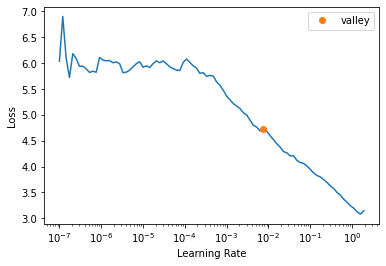

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.03       0.12
1    0.05       0.18
2    0.04       0.05
3    0.04      -0.01
4    0.34       0.20
XGBoost RMSE:  0.19226056


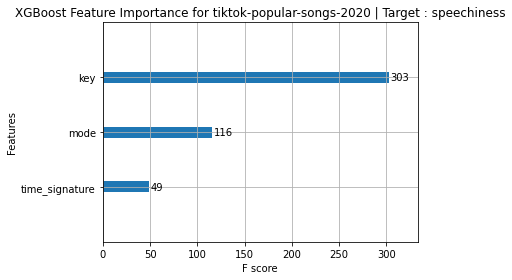

Target Variable: key
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
19
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.0393198776060375, 'Adjusted R-Squared': -0.07711332770080248, 'RMSE': 3.6562007525574676, 'Time taken': 0.01803112030029297}
{'Model': 'BaggingRegressor', 'R-Squared': 0.010054023615782892, 'Adjusted R-Squared': -0.025944011889097673, 'RMSE': 3.5682983928463865, 'Time taken': 0.02560257911682129}
{'Model': 'BayesianRidge', 'R-Squared': 0.01753421939435884, 'Adjusted R-Squared': -0.018191808991300906, 'RMSE': 3.5547915025231065, 'Time taken': 0.009205341339111328}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.004574918996679278, 'Adjusted R-Squared': -0.03162235667616886, 'RMSE': 3.5781595886531243, 'Time taken': 0.008652925491333008}
{'Model': 'DummyRegressor', 'R-Squared': -0.00020446545503238767, 'Adjusted R-Squared': -0.036575536926124474, 'RMSE': 3.58673930113424, 'Time taken': 0.008127689361572266}
{'Model': 'ElasticNet', 'R-Squared': 0.007442067992820989, 'Adjusted R-Squared': -0.028650947716531094, 'RMSE': 3.573002739118389, 'Ti

 17%|█▋        | 7/42 [00:00<00:00, 50.96it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.01824123662014132, 'Adjusted R-Squared': -0.017459082048217223, 'RMSE': 3.55351219529252, 'Time taken': 0.05808901786804199}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.004574918996679278, 'Adjusted R-Squared': -0.03162235667616886, 'RMSE': 3.5781595886531243, 'Time taken': 0.00957942008972168}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.004574918996679278, 'Adjusted R-Squared': -0.03162235667616886, 'RMSE': 3.5781595886531243, 'Time taken': 0.10346388816833496}
{'Model': 'GammaRegressor', 'R-Squared': 0.015884310226039977, 'Adjusted R-Squared': -0.0199017148566496, 'RMSE': 3.55777512947632, 'Time taken': 0.010472297668457031}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.07772485305114962, 'Adjusted R-Squared': -0.116914847707555, 'RMSE': 3.7231399900884496, 'Time taken': 0.015656709671020508}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.01584061786974489, 'Adjusted R-Squared': -0.019946996025900665, 'RMSE': 3.557854106

 31%|███       | 13/42 [00:00<00:00, 35.38it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0045763130909162175, 'Adjusted R-Squared': -0.03162091188759586, 'RMSE': 3.5781570830434593, 'Time taken': 0.05622601509094238}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.016792659787734254, 'Adjusted R-Squared': -0.01896033440180278, 'RMSE': 3.5561328177126534, 'Time taken': 0.0883638858795166}
{'Model': 'HuberRegressor', 'R-Squared': 0.013155636594344822, 'Adjusted R-Squared': -0.022729612984042635, 'RMSE': 3.5627040657842315, 'Time taken': 0.012704133987426758}


 40%|████      | 17/42 [00:00<00:00, 33.98it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.15667560321715834, 'Adjusted R-Squared': -0.19873653424323678, 'RMSE': 3.857102718273179, 'Time taken': 0.011170387268066406}
{'Model': 'KernelRidge', 'R-Squared': -2.9275359643441354, 'Adjusted R-Squared': -3.0703554539566493, 'RMSE': 7.10747764245119, 'Time taken': 0.01245570182800293}
{'Model': 'Lars', 'R-Squared': 0.015048108467960453, 'Adjusted R-Squared': -0.020768323951386503, 'RMSE': 3.5592863268641017, 'Time taken': 0.012904644012451172}
{'Model': 'LarsCV', 'R-Squared': 0.015485842686818185, 'Adjusted R-Squared': -0.020314672124570166, 'RMSE': 3.5584953265235906, 'Time taken': 0.01992201805114746}
{'Model': 'Lasso', 'R-Squared': -0.00020446545503238767, 'Adjusted R-Squared': -0.036575536926124474, 'RMSE': 3.58673930113424, 'Time taken': 0.01182103157043457}


 50%|█████     | 21/42 [00:00<00:00, 30.89it/s]

{'Model': 'LassoCV', 'R-Squared': 0.018194670371446953, 'Adjusted R-Squared': -0.017507341615045968, 'RMSE': 3.553596468423903, 'Time taken': 0.10649490356445312}
{'Model': 'LassoLars', 'R-Squared': -0.00020446545503238767, 'Adjusted R-Squared': -0.036575536926124474, 'RMSE': 3.58673930113424, 'Time taken': 0.010334014892578125}
{'Model': 'LassoLarsCV', 'R-Squared': 0.015485842686818185, 'Adjusted R-Squared': -0.020314672124570166, 'RMSE': 3.5584953265235906, 'Time taken': 0.016279220581054688}
{'Model': 'LassoLarsIC', 'R-Squared': 0.017818462127888735, 'Adjusted R-Squared': -0.01789723015836997, 'RMSE': 3.5542772369032893, 'Time taken': 0.011517047882080078}
{'Model': 'LinearRegression', 'R-Squared': 0.015048108467960453, 'Adjusted R-Squared': -0.020768323951386503, 'RMSE': 3.5592863268641017, 'Time taken': 0.009754657745361328}
{'Model': 'LinearSVR', 'R-Squared': -0.013404674213450152, 'Adjusted R-Squared': -0.050255753275757487, 'RMSE': 3.610329736978456, 'Time taken': 0.00982570648

 64%|██████▍   | 27/42 [00:01<00:00, 15.50it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.020859674053906208, 'Adjusted R-Squared': -0.05798184401950279, 'RMSE': 3.6235849005917875, 'Time taken': 0.6002788543701172}
{'Model': 'NuSVR', 'R-Squared': 0.01653197789629901, 'Adjusted R-Squared': -0.01923049563474466, 'RMSE': 3.556604212683587, 'Time taken': 0.019849300384521484}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.016792199208335634, 'Adjusted R-Squared': -0.018960811729543003, 'RMSE': 3.556133650640387, 'Time taken': 0.01434636116027832}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.016792199208335634, 'Adjusted R-Squared': -0.018960811729543003, 'RMSE': 3.556133650640387, 'Time taken': 0.01961660385131836}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.726216362317297, 'Adjusted R-Squared': -0.7889878664015624, 'RMSE': 4.711975583715324, 'Time taken': 0.01471257209777832}
{'Model': 'PoissonRegressor', 'R-Squared': 0.016981634427975845, 'Adjusted R-Squared': -0.018764487956461462, 'RMSE': 3.5557910529

 86%|████████▌ | 36/42 [00:01<00:00, 16.96it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3229216030442972, 'Adjusted R-Squared': -0.3710278431549989, 'RMSE': 4.12498592656125, 'Time taken': 0.2362513542175293}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.017360988353394502, 'Adjusted R-Squared': -0.01837133934284574, 'RMSE': 3.5551048839670454, 'Time taken': 0.13840651512145996}
{'Model': 'Ridge', 'R-Squared': 0.015124921193348406, 'Adjusted R-Squared': -0.020688718035984488, 'RMSE': 3.559147536423628, 'Time taken': 0.009274005889892578}
{'Model': 'RidgeCV', 'R-Squared': 0.015738117754963032, 'Adjusted R-Squared': -0.020053223417583865, 'RMSE': 3.5580393771802856, 'Time taken': 0.009182453155517578}
{'Model': 'SGDRegressor', 'R-Squared': 0.015236012952196898, 'Adjusted R-Squared': -0.020573586576814185, 'RMSE': 3.558946798726636, 'Time taken': 0.010663032531738281}
{'Model': 'SVR', 'R-Squared': 0.008379253352951865, 'Adjusted R-Squared': -0.027679682888758883, 'RMSE': 3.5713155042661846, 'Time taken': 0.013124465942382812}


100%|██████████| 42/42 [00:01<00:00, 22.12it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.0032333620042408473, 'Adjusted R-Squared': -0.03971457516803145, 'RMSE': 3.592166, 'Time taken': 0.058515071868896484}
{'Model': 'LGBMRegressor', 'R-Squared': 0.016792659787734254, 'Adjusted R-Squared': -0.01896033440180278, 'RMSE': 3.5561328177126534, 'Time taken': 0.022556543350219727}
Project: tiktok-popular-songs-2020
tiktok-popular-songs-2020
Target: key
key
Target Standard Deviation: 3.7068800755899898
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ElasticNetCV                                -0.02       0.02  3.55        0.06
LassoCV                                     -0.02       0.02  3.55        0.11
LassoLarsIC                                 -0.02       0.02  3.55        0.01
BayesianRidge                               -0.02       0.02  3.55        0.01
RandomForestRegressor                       -0.02       0.02  3.56      

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,78.317711,44.554062,6.674883,00:00
1,53.367977,25.645830,5.064171,00:00
2,43.762085,15.118099,3.888200,00:00
3,34.205055,18.927311,4.350553,00:00


Better model found at epoch 0 with _rmse value: 6.674882888793945.
Better model found at epoch 1 with _rmse value: 5.064171314239502.
Better model found at epoch 2 with _rmse value: 3.888200044631958.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      11       5.39
1       7       6.80
2       6       8.45
3       8       5.39
4      12       6.80
XGBoost RMSE:  3.592166


<Figure size 432x288 with 0 Axes>

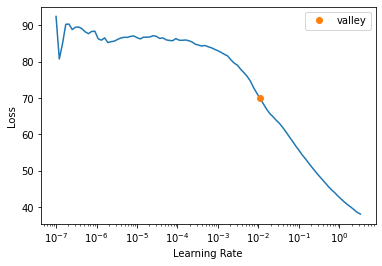

<Figure size 720x720 with 0 Axes>

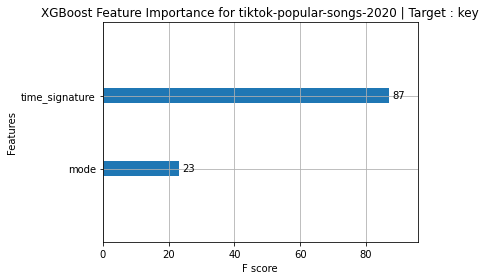

Target Variable: mode
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
19
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.0038339232494939424, 'Adjusted R-Squared': -0.040336975004021, 'RMSE': 0.49345552940871884, 'Time taken': 0.01123189926147461}
{'Model': 'BaggingRegressor', 'R-Squared': -0.0005091877879939144, 'Adjusted R-Squared': -0.03689134007119366, 'RMSE': 0.4926376800846445, 'Time taken': 0.026311874389648438}
{'Model': 'BayesianRidge', 'R-Squared': -0.026335436457575634, 'Adjusted R-Squared': -0.06365672505603293, 'RMSE': 0.4989554237681599, 'Time taken': 0.009145021438598633}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.020991135923790427, 'Adjusted R-Squared': -0.05811808632101911, 'RMSE': 0.49765465599461567, 'Time taken': 0.008807897567749023}
{'Model': 'DummyRegressor', 'R-Squared': -0.017331792092978526, 'Adjusted R-Squared': -0.054325675441814214, 'RMSE': 0.496762031118722, 'Time taken': 0.008324146270751953}
{'Model': 'ElasticNet', 'R-Squared': -0.017331792092978526, 'Adjusted R-Squared': -0.054325675441814214, 'RMSE': 0.4967620311187

 17%|█▋        | 7/42 [00:00<00:00, 52.94it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.03231768760562126, 'Adjusted R-Squared': -0.0028707601178106223, 'RMSE': 0.4844885160149419, 'Time taken': 0.010637283325195312}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.031059721679099983, 'Adjusted R-Squared': -0.0685528024674309, 'RMSE': 0.5001024665785271, 'Time taken': 0.1271498203277588}
{'Model': 'GammaRegressor', 'R-Squared': -0.02055835427305941, 'Adjusted R-Squared': -0.05766956715571614, 'RMSE': 0.4975491709299779, 'Time taken': 0.010524272918701172}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.0020347386276255985, 'Adjusted R-Squared': -0.03847236548681199, 'RMSE': 0.49301311769689016, 'Time taken': 0.021857500076293945}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.01957745809434308, 'Adjusted R-Squared': -0.05665300202504642, 'RMSE': 0.4973100070428202, 'Time taken': 0.03084874153137207}


 31%|███       | 13/42 [00:00<00:01, 27.59it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.024588146024517865, 'Adjusted R-Squared': -0.010881375938226912, 'RMSE': 0.4864196382344822, 'Time taken': 0.09593009948730469}


 40%|████      | 17/42 [00:00<00:00, 26.75it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.04827833623440958, 'Adjusted R-Squared': 0.013670275733842607, 'RMSE': 0.4804764027635289, 'Time taken': 0.11107850074768066}
{'Model': 'HuberRegressor', 'R-Squared': -0.05586568581737028, 'Adjusted R-Squared': -0.09426080166527462, 'RMSE': 0.5060826211101375, 'Time taken': 0.014002799987792969}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.17137254901960808, 'Adjusted R-Squared': -0.21396791443850294, 'RMSE': 0.5330458995569545, 'Time taken': 0.010133504867553711}
{'Model': 'KernelRidge', 'R-Squared': -10.132179592008207, 'Adjusted R-Squared': -10.536986122626686, 'RMSE': 1.6432634205042325, 'Time taken': 0.02176189422607422}
{'Model': 'Lars', 'R-Squared': -0.04165647773439374, 'Adjusted R-Squared': -0.07953489510655354, 'RMSE': 0.5026658083975925, 'Time taken': 0.0171506404876709}


 48%|████▊     | 20/42 [00:00<00:00, 26.94it/s]

{'Model': 'LarsCV', 'R-Squared': -0.04165647773439374, 'Adjusted R-Squared': -0.07953489510655354, 'RMSE': 0.5026658083975925, 'Time taken': 0.04312849044799805}
{'Model': 'Lasso', 'R-Squared': -0.017331792092978526, 'Adjusted R-Squared': -0.054325675441814214, 'RMSE': 0.496762031118722, 'Time taken': 0.037674665451049805}


 55%|█████▍    | 23/42 [00:00<00:00, 27.72it/s]

{'Model': 'LassoCV', 'R-Squared': -0.03551501840280635, 'Adjusted R-Squared': -0.07317010998109019, 'RMSE': 0.5011817945082, 'Time taken': 0.06522655487060547}
{'Model': 'LassoLars', 'R-Squared': -0.017331792092978526, 'Adjusted R-Squared': -0.054325675441814214, 'RMSE': 0.496762031118722, 'Time taken': 0.009677410125732422}
{'Model': 'LassoLarsCV', 'R-Squared': -0.04165647773439374, 'Adjusted R-Squared': -0.07953489510655354, 'RMSE': 0.5026658083975925, 'Time taken': 0.016136646270751953}
{'Model': 'LassoLarsIC', 'R-Squared': -0.04165647773439374, 'Adjusted R-Squared': -0.07953489510655354, 'RMSE': 0.5026658083975925, 'Time taken': 0.010539054870605469}
{'Model': 'LinearRegression', 'R-Squared': -0.04165647773439396, 'Adjusted R-Squared': -0.07953489510655376, 'RMSE': 0.5026658083975926, 'Time taken': 0.009324312210083008}
{'Model': 'LinearSVR', 'R-Squared': -0.20157793356277254, 'Adjusted R-Squared': -0.2452716766014189, 'RMSE': 0.5398748021144826, 'Time taken': 0.010151147842407227}

 79%|███████▊  | 33/42 [00:01<00:00, 17.58it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.5325798673619919, 'Adjusted R-Squared': -0.5883100443569735, 'RMSE': 0.6097174770607686, 'Time taken': 0.6280701160430908}
{'Model': 'NuSVR', 'R-Squared': -0.03052102883430341, 'Adjusted R-Squared': -0.06799452079191437, 'RMSE': 0.4999718064372252, 'Time taken': 0.023253440856933594}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.046471162291767176, 'Adjusted R-Squared': 0.01179738637510419, 'RMSE': 0.4809323620343484, 'Time taken': 0.013814449310302734}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.04165647773439374, 'Adjusted R-Squared': -0.07953489510655354, 'RMSE': 0.5026658083975925, 'Time taken': 0.019613981246948242}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -6.50720583858146, 'Adjusted R-Squared': -6.780195141802604, 'RMSE': 1.3494482913132322, 'Time taken': 0.0136566162109375}
{'Model': 'PoissonRegressor', 'R-Squared': -0.02616365535571541, 'Adjusted R-Squared': -0.06347869736865053, 'RMSE': 0.4989136661243

100%|██████████| 42/42 [00:01<00:00, 22.41it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.0004885696233313253, 'Adjusted R-Squared': -0.03585730057218384, 'RMSE': 0.49239197744203267, 'Time taken': 0.14485669136047363}
{'Model': 'Ridge', 'R-Squared': -0.04139947714023129, 'Adjusted R-Squared': -0.0792685490362397, 'RMSE': 0.5026037949682995, 'Time taken': 0.009972572326660156}
{'Model': 'RidgeCV', 'R-Squared': -0.03922525595054327, 'Adjusted R-Squared': -0.07701526525783575, 'RMSE': 0.502078855783022, 'Time taken': 0.008867979049682617}
{'Model': 'SGDRegressor', 'R-Squared': -0.050473290985271424, 'Adjusted R-Squared': -0.08867231974837231, 'RMSE': 0.5047886636599187, 'Time taken': 0.01013493537902832}
{'Model': 'SVR', 'R-Squared': -0.009752520513834684, 'Adjusted R-Squared': -0.046470793987064996, 'RMSE': 0.49490809651992734, 'Time taken': 0.012115955352783203}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.04165647773439396, 'Adjusted R-Squared': -0.07953489510655376, 'RMSE': 0.5026658083975926, 'Time taken': 0.00

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,6.563239,1.359171,1.165835,00:00
1,5.658827,0.469329,0.685076,00:00
2,5.603810,0.623364,0.789534,00:00


Better model found at epoch 0 with _rmse value: 1.165834903717041.
Better model found at epoch 1 with _rmse value: 0.6850759983062744.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.68
1       2       1.50
2       1       1.29
3       2       1.52
4       2       1.50
XGBoost RMSE:  0.49474317


<Figure size 432x288 with 0 Axes>

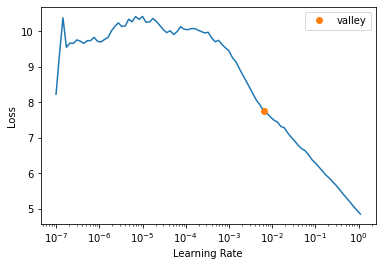

<Figure size 720x720 with 0 Axes>

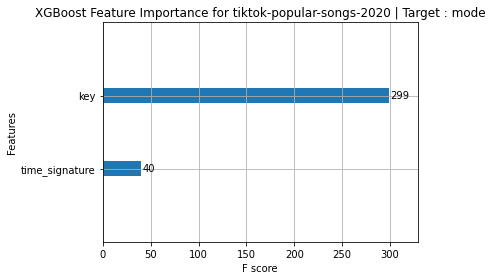

Target Variable: loudness
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.1321139141889245, 'Adjusted R-Squared': -0.19500913164386469, 'RMSE': 2.7938408111062234, 'Time taken': 0.03336381912231445}
{'Model': 'BaggingRegressor', 'R-Squared': -0.025760565757905418, 'Adjusted R-Squared': -0.08274726385556685, 'RMSE': 2.659375065834522, 'Time taken': 0.027721643447875977}
{'Model': 'BayesianRidge', 'R-Squared': 0.04127915972832996, 'Adjusted R-Squared': -0.011983109175651707, 'RMSE': 2.5710035539139486, 'Time taken': 0.00959634780883789}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.09933953019905006, 'Adjusted R-Squared': -0.1604139485434417, 'RMSE': 2.753103352762985, 'Time taken': 0.009229898452758789}
{'Model': 'DummyRegressor', 'R-Squared': -6.485615684304058e-05, 'Adjusted R-Squared': -0.055624014832223345, 'RMSE': 2.6258545, 'Time taken': 0.008411407470703125}
{'Model': 'ElasticNet', 'R-Squared': -6.481646011158304e-05, 'Adjusted R-Squared': -0.05562397293011778, 'RMSE': 2.6258545562720554, 'Time taken'

 17%|█▋        | 7/42 [00:00<00:00, 44.81it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.045316018222448684, 'Adjusted R-Squared': -0.007721980765193148, 'RMSE': 2.565585018316001, 'Time taken': 0.05797290802001953}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.15870476594512417, 'Adjusted R-Squared': -0.22307725294207548, 'RMSE': 2.826460949618274, 'Time taken': 0.010806798934936523}


 29%|██▊       | 12/42 [00:00<00:00, 34.31it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.1430659432617094, 'Adjusted R-Squared': -0.2065696067762488, 'RMSE': 2.8073220428388805, 'Time taken': 0.10922002792358398}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.546891365317066, 'Adjusted R-Squared': -5.910607552279125, 'RMSE': 6.718528445755301, 'Time taken': 0.02267932891845703}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.032476717155318524, 'Adjusted R-Squared': -0.021274576336052675, 'RMSE': 2.5827793497073954, 'Time taken': 0.02809309959411621}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.020508708222115146, 'Adjusted R-Squared': -0.07720363645667705, 'RMSE': 2.6525583765611382, 'Time taken': 0.09833216667175293}


 38%|███▊      | 16/42 [00:00<00:01, 24.45it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.015487949807076351, 'Adjusted R-Squared': -0.039207164092530444, 'RMSE': 2.605356220053287, 'Time taken': 0.11659550666809082}
{'Model': 'HuberRegressor', 'R-Squared': 0.008167794588152755, 'Adjusted R-Squared': -0.04693399460139425, 'RMSE': 2.6150241018539946, 'Time taken': 0.013900041580200195}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.013502536884965277, 'Adjusted R-Squared': -0.0413028777325366, 'RMSE': 2.607982, 'Time taken': 0.010558128356933594}
{'Model': 'KernelRidge', 'R-Squared': -6.952998025273441, 'Adjusted R-Squared': -7.394831248899743, 'RMSE': 7.404948292915684, 'Time taken': 0.02659440040588379}
{'Model': 'Lars', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.0209505558013916}


 45%|████▌     | 19/42 [00:00<00:00, 25.59it/s]

{'Model': 'LarsCV', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.05295157432556152}
{'Model': 'Lasso', 'R-Squared': -6.481646011158304e-05, 'Adjusted R-Squared': -0.05562397293011778, 'RMSE': 2.6258545562720554, 'Time taken': 0.03658747673034668}


 52%|█████▏    | 22/42 [00:00<00:00, 25.60it/s]

{'Model': 'LassoCV', 'R-Squared': 0.04698293847990953, 'Adjusted R-Squared': -0.005962453826762193, 'RMSE': 2.563344227569208, 'Time taken': 0.06717252731323242}
{'Model': 'LassoLars', 'R-Squared': -6.481646011158304e-05, 'Adjusted R-Squared': -0.05562397293011778, 'RMSE': 2.6258545562720554, 'Time taken': 0.010744094848632812}
{'Model': 'LassoLarsCV', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.018270254135131836}
{'Model': 'LassoLarsIC', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.010774850845336914}
{'Model': 'LinearRegression', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.009503602981567383}
{'Model': 'LinearSVR', 'R-Squared': -0.014469911531306945, 'Adjusted R-Squared': -0.070829351060824, 'RMSE': 2.6446985573578776, 'Time taken': 0.0099351406097412

 79%|███████▊  | 33/42 [00:01<00:00, 18.61it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.015401379114562408, 'Adjusted R-Squared': -0.0718125668431493, 'RMSE': 2.6459124355277948, 'Time taken': 0.5990321636199951}
{'Model': 'NuSVR', 'R-Squared': -0.029643806118954785, 'Adjusted R-Squared': -0.08684623979223005, 'RMSE': 2.6644041328610757, 'Time taken': 0.021085023880004883}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.028713775242521167, 'Adjusted R-Squared': -0.02524657057733881, 'RMSE': 2.587797015642345, 'Time taken': 0.015260934829711914}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.020935535430908203}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5786202676844214, 'Adjusted R-Squared': -0.6663213936668893, 'RMSE': 3.299099623065611, 'Time taken': 0.01433563232421875}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution
{'Model'

100%|██████████| 42/42 [00:01<00:00, 22.59it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.01589613696316894, 'Adjusted R-Squared': -0.03877629987221054, 'RMSE': 2.6048160625204377, 'Time taken': 0.1502394676208496}
{'Model': 'Ridge', 'R-Squared': 0.0469517128540331, 'Adjusted R-Squared': -0.005995414209631678, 'RMSE': 2.563386221241431, 'Time taken': 0.009943962097167969}
{'Model': 'RidgeCV', 'R-Squared': 0.04645964511659417, 'Adjusted R-Squared': -0.006514819043595077, 'RMSE': 2.5640478859777045, 'Time taken': 0.008971691131591797}
{'Model': 'SGDRegressor', 'R-Squared': 0.04664551139424411, 'Adjusted R-Squared': -0.006318626861631316, 'RMSE': 2.5637979787453378, 'Time taken': 0.012035608291625977}
{'Model': 'SVR', 'R-Squared': -0.0055915366823977575, 'Adjusted R-Squared': -0.061457733164753225, 'RMSE': 2.633100270902928, 'Time taken': 0.012231588363647461}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.04700277880523951, 'Adjusted R-Squared': -0.005941511261136068, 'RMSE': 2.5633175450206167, 'Time taken': 0.0095934

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,98.150146,51.464565,7.173881,00:00
1,63.245800,29.706141,5.450334,00:00
2,48.515396,11.279490,3.358495,00:00
3,41.736488,11.049981,3.324151,00:00
4,35.080620,10.376143,3.221202,00:00
5,30.392115,9.880813,3.143376,00:00
6,26.994476,11.780098,3.432215,00:00


Better model found at epoch 0 with _rmse value: 7.173880577087402.
Better model found at epoch 1 with _rmse value: 5.450334072113037.
Better model found at epoch 2 with _rmse value: 3.3584952354431152.
Better model found at epoch 3 with _rmse value: 3.3241512775421143.
Better model found at epoch 4 with _rmse value: 3.2212021350860596.
Better model found at epoch 5 with _rmse value: 3.143376111984253.
No improvement since epoch 5: early stopping


,mode,key,time_signature,loudness,loudness_pred
0,1.00,12.00,3.00,-6.82,-5.11
1,2.00,2.00,3.00,-3.88,-6.62
2,2.00,7.00,3.00,-7.56,-5.03
3,2.00,1.00,2.00,-10.23,-4.80
4,1.00,2.00,3.00,-6.15,-4.99
5,2.00,2.00,3.00,-15.77,-6.62
6,2.00,10.00,3.00,-3.76,-5.38
7,2.00,1.00,3.00,-2.99,-5.61
8,2.00,2.00,3.00,-10.06,-6.62


<Figure size 432x288 with 0 Axes>

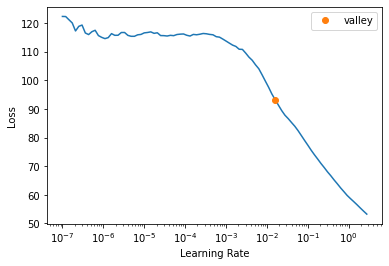

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   -8.44      -7.29
1  -10.23      -3.71
2   -7.56      -3.23
3   -6.15      -7.29
4   -7.58      -6.73
XGBoost RMSE:  2.8256764


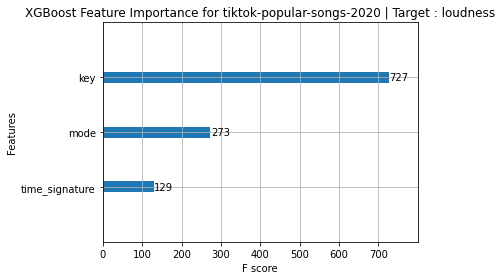

Target Variable: energy
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.047519064559424784, 'Adjusted R-Squared': -0.10571456814605962, 'RMSE': 0.1619152948384987, 'Time taken': 0.02388596534729004}
{'Model': 'BaggingRegressor', 'R-Squared': -0.10140035043064044, 'Adjusted R-Squared': -0.16258925878789832, 'RMSE': 0.1660273026744799, 'Time taken': 0.027978897094726562}
{'Model': 'BayesianRidge', 'R-Squared': -0.017161945864156314, 'Adjusted R-Squared': -0.07367094285660958, 'RMSE': 0.1595518922168111, 'Time taken': 0.009389638900756836}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.10621879176757498, 'Adjusted R-Squared': -0.16767539131021802, 'RMSE': 0.1663900771043768, 'Time taken': 0.00902104377746582}
{'Model': 'DummyRegressor', 'R-Squared': -0.01556562789765481, 'Adjusted R-Squared': -0.07198594055863561, 'RMSE': 0.15942664, 'Time taken': 0.008369684219360352}
{'Model': 'ElasticNet', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time tak

 17%|█▋        | 7/42 [00:00<00:00, 47.93it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.057849884033203125}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.10621879176757498, 'Adjusted R-Squared': -0.16767539131021802, 'RMSE': 0.1663900771043768, 'Time taken': 0.010533332824707031}


 29%|██▊       | 12/42 [00:00<00:00, 34.62it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.10621879176757365, 'Adjusted R-Squared': -0.1676753913102167, 'RMSE': 0.1663900771043767, 'Time taken': 0.10942411422729492}
{'Model': 'GammaRegressor', 'R-Squared': -0.0172424408439793, 'Adjusted R-Squared': -0.07375590977975599, 'RMSE': 0.15955820530801348, 'Time taken': 0.010998964309692383}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.1277045708258575, 'Adjusted R-Squared': -0.19035482476062748, 'RMSE': 0.16799818025108032, 'Time taken': 0.022894859313964844}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': -0.016834974166689998, 'Adjusted R-Squared': -0.0733258060648394, 'RMSE': 0.15952624578636326, 'Time taken': 0.02849292755126953}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.11339979165583891, 'Adjusted R-Squared': -0.1752553356367188, 'RMSE': 0.1669292626253706, 'Time taken': 0.09765100479125977}


 38%|███▊      | 16/42 [00:00<00:01, 24.32it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.15605481457685944, 'Adjusted R-Squared': -0.2202800820533517, 'RMSE': 0.17009679103521444, 'Time taken': 0.12121796607971191}
{'Model': 'HuberRegressor', 'R-Squared': -0.020293586634710925, 'Adjusted R-Squared': -0.07697656366997263, 'RMSE': 0.15979731784229953, 'Time taken': 0.014422893524169922}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.09630994538377169, 'Adjusted R-Squared': -0.15721605346064793, 'RMSE': 0.16564319, 'Time taken': 0.010869026184082031}
{'Model': 'KernelRidge', 'R-Squared': -15.616498384134793, 'Adjusted R-Squared': -16.539637183253394, 'RMSE': 0.6448766646695848, 'Time taken': 0.025559186935424805}
{'Model': 'Lars', 'R-Squared': -0.021146164875213813, 'Adjusted R-Squared': -0.07787650736828122, 'RMSE': 0.15986406885817256, 'Time taken': 0.027213573455810547}


 45%|████▌     | 19/42 [00:00<00:00, 24.85it/s]

{'Model': 'LarsCV', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.05041193962097168}
{'Model': 'Lasso', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.025696516036987305}


 52%|█████▏    | 22/42 [00:00<00:00, 25.76it/s]

{'Model': 'LassoCV', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.06566476821899414}
{'Model': 'LassoLars', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.009760379791259766}
{'Model': 'LassoLarsCV', 'R-Squared': -0.015565553315536773, 'Adjusted R-Squared': -0.07198586183306666, 'RMSE': 0.15942663808715793, 'Time taken': 0.016742467880249023}
{'Model': 'LassoLarsIC', 'R-Squared': -0.011731670238043668, 'Adjusted R-Squared': -0.0679389852512684, 'RMSE': 0.1591254260976332, 'Time taken': 0.010572433471679688}
{'Model': 'LinearRegression', 'R-Squared': -0.021146164875213813, 'Adjusted R-Squared': -0.07787650736828122, 'RMSE': 0.15986406885817256, 'Time taken': 0.009166240692138672}
{'Model': 'LinearSVR', 'R-Squared': -0.011075102597609465, 'Adjusted R-Squared': -0.06724594163080999, 'RMSE': 0.15907378515159076, 'Time taken': 0.011933

 74%|███████▍  | 31/42 [00:01<00:00, 23.45it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.046751677661097, 'Adjusted R-Squared': -0.10490454864226906, 'RMSE': 0.1618559763762493, 'Time taken': 0.27480340003967285}
{'Model': 'NuSVR', 'R-Squared': -0.09828855029714134, 'Adjusted R-Squared': -0.15930458086920485, 'RMSE': 0.16579259727472562, 'Time taken': 0.04519820213317871}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.008770803214800837, 'Adjusted R-Squared': -0.0648136256156231, 'RMSE': 0.15889241251585454, 'Time taken': 0.020601272583007812}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.021146164875213813, 'Adjusted R-Squared': -0.07787650736828122, 'RMSE': 0.15986406885817256, 'Time taken': 0.020236492156982422}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -2.256910968189452, 'Adjusted R-Squared': -2.4378504664221996, 'RMSE': 0.28550245727149304, 'Time taken': 0.012349367141723633}
{'Model': 'PoissonRegressor', 'R-Squared': -0.01621386466732, 'Adjusted R-Squared': -0.07267019048217116, 'RMSE': 0.159477

100%|██████████| 42/42 [00:01<00:00, 27.01it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.09531812854070898, 'Adjusted R-Squared': -0.15616913568185953, 'RMSE': 0.16556824486109212, 'Time taken': 0.14905118942260742}
{'Model': 'Ridge', 'R-Squared': -0.021097360187666725, 'Adjusted R-Squared': -0.07782499130920373, 'RMSE': 0.15986024853869976, 'Time taken': 0.010271072387695312}
{'Model': 'RidgeCV', 'R-Squared': -0.02068474331754211, 'Adjusted R-Squared': -0.07738945127962782, 'RMSE': 0.15982794618296794, 'Time taken': 0.008971691131591797}
{'Model': 'SGDRegressor', 'R-Squared': -0.03406061700886953, 'Adjusted R-Squared': -0.09150842906491796, 'RMSE': 0.16087179442624186, 'Time taken': 0.008814573287963867}
{'Model': 'SVR', 'R-Squared': -0.1182429287063087, 'Adjusted R-Squared': -0.1803675358566592, 'RMSE': 0.16729192841513546, 'Time taken': 0.011343240737915039}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.021146164875213813, 'Adjusted R-Squared': -0.07787650736828122, 'RMSE': 0.15986406885817256, 'Time taken': 0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,10.447150,0.098379,0.313654,00:00
1,8.817780,0.090279,0.300464,00:00
2,7.958855,0.359426,0.599521,00:00


Better model found at epoch 0 with _rmse value: 0.3136538863182068.
Better model found at epoch 1 with _rmse value: 0.30046436190605164.
No improvement since epoch 1: early stopping


,mode,key,time_signature,energy,energy_pred
0,2.00,10.00,3.00,0.80,0.75
1,2.00,5.00,3.00,0.93,0.76
2,1.00,12.00,3.00,0.50,0.82
3,2.00,10.00,3.00,0.65,0.75
4,2.00,2.00,3.00,0.39,0.91
5,1.00,2.00,3.00,0.82,0.93
6,2.00,1.00,3.00,0.66,0.73
7,1.00,12.00,3.00,0.21,0.82
8,1.00,5.00,3.00,0.50,0.90


<Figure size 432x288 with 0 Axes>

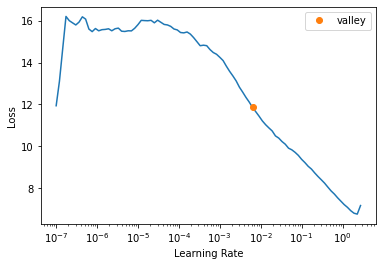

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.44       0.61
1    0.39       0.63
2    0.73       0.66
3    0.87       0.63
4    0.75       0.59
XGBoost RMSE:  0.1663725


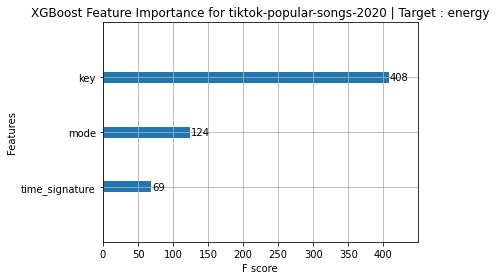

Target Variable: danceability
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'track_pop', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'track_pop', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.03991505869710932, 'Adjusted R-Squared': -0.0976881175136155, 'RMSE': 0.15565192526516383, 'Time taken': 0.027426481246948242}
{'Model': 'BaggingRegressor', 'R-Squared': -0.059272153924617044, 'Adjusted R-Squared': -0.11812060692042903, 'RMSE': 0.15709390707583082, 'Time taken': 0.02646327018737793}
{'Model': 'BayesianRidge', 'R-Squared': -0.006295824789187554, 'Adjusted R-Squared': -0.062201148388586924, 'RMSE': 0.15311523268234925, 'Time taken': 0.00943899154663086}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.0927286137248935, 'Adjusted R-Squared': -0.15343575893183203, 'RMSE': 0.15955547860912736, 'Time taken': 0.009235620498657227}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011582123446314263, 'Adjusted R-Squared': -0.05677811303044433, 'RMSE': 0.15272388, 'Time taken': 0.00887918472290039}
{'Model': 'ElasticNet', 'R-Squared': -0.0011581826969422337, 'Adjusted R-Squared': -0.056778081735661345, 'RMSE': 0.15272386769897126, 'Ti

 17%|█▋        | 7/42 [00:00<00:00, 46.31it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.009634396022736746, 'Adjusted R-Squared': -0.06572519580177771, 'RMSE': 0.1533690163173846, 'Time taken': 0.05987048149108887}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.0927286137248935, 'Adjusted R-Squared': -0.15343575893183203, 'RMSE': 0.15955547860912736, 'Time taken': 0.011645078659057617}


 29%|██▊       | 12/42 [00:00<00:00, 35.27it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.0927286137248926, 'Adjusted R-Squared': -0.15343575893183115, 'RMSE': 0.15955547860912728, 'Time taken': 0.11135673522949219}
{'Model': 'GammaRegressor', 'R-Squared': 0.0053621628171152125, 'Adjusted R-Squared': -0.049895494804156115, 'RMSE': 0.15222572510437962, 'Time taken': 0.011338949203491211}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.08431963331183501, 'Adjusted R-Squared': -0.14455961294027042, 'RMSE': 0.1589403715808452, 'Time taken': 0.024640321731567383}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.0010927758766701157, 'Adjusted R-Squared': -0.05440206990795926, 'RMSE': 0.15255208238324958, 'Time taken': 0.0144195556640625}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.08889677690136732, 'Adjusted R-Squared': -0.14939104228477662, 'RMSE': 0.159275478855095, 'Time taken': 0.10941910743713379}


 38%|███▊      | 16/42 [00:00<00:01, 24.34it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.09552465662339338, 'Adjusted R-Squared': -0.15638713754691524, 'RMSE': 0.15975948120386413, 'Time taken': 0.11404824256896973}
{'Model': 'HuberRegressor', 'R-Squared': -0.0030171663023998985, 'Adjusted R-Squared': -0.05874034220808877, 'RMSE': 0.15286559330209143, 'Time taken': 0.015358924865722656}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.13437388272386275, 'Adjusted R-Squared': -0.19739465398629963, 'RMSE': 0.16256747, 'Time taken': 0.011034727096557617}
{'Model': 'KernelRidge', 'R-Squared': -21.967367578783595, 'Adjusted R-Squared': -23.243332444271573, 'RMSE': 0.7314946831697213, 'Time taken': 0.013717174530029297}
{'Model': 'Lars', 'R-Squared': -0.010303263278809371, 'Adjusted R-Squared': -0.06643122234985444, 'RMSE': 0.15341981021324452, 'Time taken': 0.013191699981689453}
{'Model': 'LarsCV', 'R-Squared': -0.009555390311741796, 'Adjusted R-Squared': -0.06564180088461646, 'RMSE': 0.15336301549902867, 'Time taken': 

 50%|█████     | 21/42 [00:00<00:00, 25.11it/s]

{'Model': 'LassoCV', 'R-Squared': -0.009643701863392362, 'Adjusted R-Squared': -0.06573501863358078, 'RMSE': 0.1533697231199382, 'Time taken': 0.0944666862487793}
{'Model': 'LassoLars', 'R-Squared': -0.0011581826969422337, 'Adjusted R-Squared': -0.056778081735661345, 'RMSE': 0.15272386769897126, 'Time taken': 0.010586738586425781}
{'Model': 'LassoLarsCV', 'R-Squared': -0.009555390311741796, 'Adjusted R-Squared': -0.06564180088461646, 'RMSE': 0.15336301549902867, 'Time taken': 0.017606735229492188}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0004708392662750027, 'Adjusted R-Squared': -0.05505855855226538, 'RMSE': 0.15259956575268066, 'Time taken': 0.01091909408569336}
{'Model': 'LinearRegression', 'R-Squared': -0.010303263278809371, 'Adjusted R-Squared': -0.06643122234985444, 'RMSE': 0.15341981021324452, 'Time taken': 0.009508848190307617}
{'Model': 'LinearSVR', 'R-Squared': -0.003609583528222604, 'Adjusted R-Squared': -0.05936567150201277, 'RMSE': 0.15291073053686952, 'Time taken': 0.01256

 74%|███████▍  | 31/42 [00:01<00:00, 24.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0030423228595175544, 'Adjusted R-Squared': -0.05234421475939821, 'RMSE': 0.152403143273814, 'Time taken': 0.2641427516937256}
{'Model': 'NuSVR', 'R-Squared': -0.04254493447839547, 'Adjusted R-Squared': -0.1004640975049731, 'RMSE': 0.15584861765373098, 'Time taken': 0.046025753021240234}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.053117816037916654, 'Adjusted R-Squared': 0.0005132502622453572, 'RMSE': 0.14852635936268563, 'Time taken': 0.023158788681030273}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.016464358588426986, 'Adjusted R-Squared': -0.07293460073222846, 'RMSE': 0.15388689639082506, 'Time taken': 0.01734304428100586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.019098688270690944, 'Adjusted R-Squared': -0.0757152820635072, 'RMSE': 0.1540861785878824, 'Time taken': 0.012096643447875977}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0016712877491661393, 'Adjusted R-Squared': -0.05379141848699143, 'RMSE': 0

100%|██████████| 42/42 [00:01<00:00, 27.32it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.06820248484545877, 'Adjusted R-Squared': -0.12754706733687327, 'RMSE': 0.15775471748968314, 'Time taken': 0.1491100788116455}
{'Model': 'Ridge', 'R-Squared': -0.010146370190677434, 'Adjusted R-Squared': -0.06626561297904843, 'RMSE': 0.15340789723461318, 'Time taken': 0.011137247085571289}
{'Model': 'RidgeCV', 'R-Squared': -0.0088348502855351, 'Adjusted R-Squared': -0.06488123085695374, 'RMSE': 0.15330827659288546, 'Time taken': 0.008962154388427734}
{'Model': 'SGDRegressor', 'R-Squared': -0.0062406924206901415, 'Adjusted R-Squared': -0.06214295311072848, 'RMSE': 0.15311103822936162, 'Time taken': 0.009064197540283203}
{'Model': 'SVR', 'R-Squared': -0.05713282931794472, 'Adjusted R-Squared': -0.11586243094671955, 'RMSE': 0.15693519209547552, 'Time taken': 0.012295007705688477}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.010303263278809371, 'Adjusted R-Squared': -0.06643122234985444, 'RMSE': 0.15341981021324452, 'Time taken':

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,6.569831,0.125670,0.354499,00:00
1,5.383525,0.025039,0.158237,00:00
2,4.456106,0.107557,0.327959,00:00


Better model found at epoch 0 with _rmse value: 0.35449907183647156.
Better model found at epoch 1 with _rmse value: 0.158237025141716.
No improvement since epoch 1: early stopping


,mode,key,time_signature,danceability,danceability_pred
0,2.00,12.00,3.00,0.80,0.72
1,1.00,11.00,3.00,0.90,0.82
2,2.00,2.00,3.00,0.93,0.66
3,2.00,3.00,3.00,0.69,0.78
4,2.00,2.00,3.00,0.37,0.66
5,1.00,7.00,3.00,0.65,0.80
6,2.00,3.00,3.00,0.57,0.78
7,2.00,1.00,3.00,0.55,0.68
8,2.00,2.00,3.00,0.66,0.66


<Figure size 432x288 with 0 Axes>

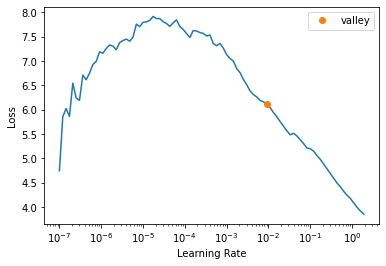

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.50       0.76
1    0.92       0.66
2    0.80       0.72
3    0.93       0.82
4    0.77       0.70
XGBoost RMSE:  0.15937798


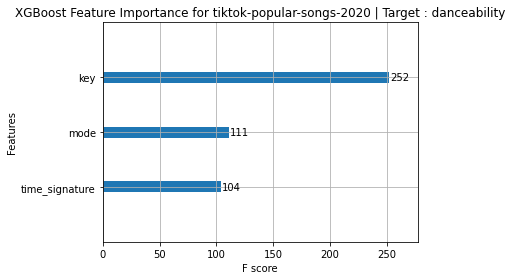

Target Variable: track_pop
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'artist_pop', 'album', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['artist_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.06267232263258671, 'Adjusted R-Squared': 0.010598562778841525, 'RMSE': 20.266944129799967, 'Time taken': 0.020417213439941406}
{'Model': 'BaggingRegressor', 'R-Squared': -0.07746140063269547, 'Adjusted R-Squared': -0.1373203673345118, 'RMSE': 21.729183632604855, 'Time taken': 0.02748394012451172}
{'Model': 'BayesianRidge', 'R-Squared': -0.009616885952431709, 'Adjusted R-Squared': -0.06570671294978903, 'RMSE': 21.033950742108136, 'Time taken': 0.009675741195678711}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.06877415028748524, 'Adjusted R-Squared': -0.1281504919701233, 'RMSE': 21.641408380371484, 'Time taken': 0.011775970458984375}
{'Model': 'DummyRegressor', 'R-Squared': -0.009638009273648551, 'Adjusted R-Squared': -0.06572900978885121, 'RMSE': 21.03417, 'Time taken': 0.012664318084716797}
{'Model': 'ElasticNet', 'R-Squared': -0.003982704248279845, 'Adjusted R-Squared': -0.05975952115096206, 'RMSE': 20.975178498660405, 'Time taken': 

 17%|█▋        | 7/42 [00:00<00:00, 46.57it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.05780529975891113}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.05702136657919388, 'Adjusted R-Squared': -0.11574477583359366, 'RMSE': 21.522089488444912, 'Time taken': 0.010064363479614258}


 29%|██▊       | 12/42 [00:00<00:00, 37.07it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.05512154689999704, 'Adjusted R-Squared': -0.1137394106166636, 'RMSE': 21.50273960614782, 'Time taken': 0.1095881462097168}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.2421069715762203, 'Adjusted R-Squared': -0.31111291444156586, 'RMSE': 23.330392725487226, 'Time taken': 0.0207366943359375}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.0021494301184006304, 'Adjusted R-Squared': -0.053286712652799384, 'RMSE': 20.911024198470436, 'Time taken': 0.013587713241577148}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.03171227993587422, 'Adjusted R-Squared': -0.08902962882120069, 'RMSE': 21.262868319911284, 'Time taken': 0.11110544204711914}


 38%|███▊      | 16/42 [00:00<00:01, 24.67it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.008986973492841166, 'Adjusted R-Squared': -0.04606930575755652, 'RMSE': 20.83925703383098, 'Time taken': 0.11465263366699219}
{'Model': 'HuberRegressor', 'R-Squared': -0.08414460309396898, 'Adjusted R-Squared': -0.14437485882141177, 'RMSE': 21.796469587444143, 'Time taken': 0.015048503875732422}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.07395301102304308, 'Adjusted R-Squared': -0.13361706719098998, 'RMSE': 21.693779, 'Time taken': 0.010270118713378906}
{'Model': 'KernelRidge', 'R-Squared': -8.105830261796964, 'Adjusted R-Squared': -8.611709720785685, 'RMSE': 63.1687561049276, 'Time taken': 0.03153848648071289}


 45%|████▌     | 19/42 [00:00<00:00, 25.27it/s]

{'Model': 'Lars', 'R-Squared': 0.011194089083003234, 'Adjusted R-Squared': -0.043739572634607704, 'RMSE': 20.81603822366537, 'Time taken': 0.03403043746948242}
{'Model': 'LarsCV', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.04177236557006836}
{'Model': 'Lasso', 'R-Squared': -0.009303835287247653, 'Adjusted R-Squared': -0.06537627058098372, 'RMSE': 21.03068950367755, 'Time taken': 0.028344392776489258}


 52%|█████▏    | 22/42 [00:00<00:00, 25.50it/s]

{'Model': 'LassoCV', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.06906676292419434}
{'Model': 'LassoLars', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.009796142578125}
{'Model': 'LassoLarsCV', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.016695261001586914}
{'Model': 'LassoLarsIC', 'R-Squared': -0.009637993055467087, 'Adjusted R-Squared': -0.06572899266965981, 'RMSE': 21.034170609392135, 'Time taken': 0.010604619979858398}
{'Model': 'LinearRegression', 'R-Squared': 0.011194089083003234, 'Adjusted R-Squared': -0.043739572634607704, 'RMSE': 20.81603822366537, 'Time taken': 0.009426355361938477}
{'Model': 'LinearSVR', 'R-Squared': -0.007138943240489137, 'Adjusted R-Squared': -0.06309110675384977, 'RMSE': 21.008122655440324, 'Time taken': 0.01487827301025

 79%|███████▊  | 33/42 [00:01<00:00, 18.70it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.0706373928246435, 'Adjusted R-Squared': -2.2412283590926796, 'RMSE': 36.68232183636398, 'Time taken': 0.5805118083953857}
{'Model': 'NuSVR', 'R-Squared': -0.0663707403061673, 'Adjusted R-Squared': -0.12561355921206552, 'RMSE': 21.617061585012756, 'Time taken': 0.01943826675415039}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0046134617348101425, 'Adjusted R-Squared': -0.060425320720077336, 'RMSE': 20.981766347968943, 'Time taken': 0.013506412506103516}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0046134617348101425, 'Adjusted R-Squared': -0.060425320720077336, 'RMSE': 20.981766347968943, 'Time taken': 0.020389795303344727}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.32918724663111165, 'Adjusted R-Squared': -0.4030309825550624, 'RMSE': 24.134351440307665, 'Time taken': 0.013638496398925781}
{'Model': 'PoissonRegressor', 'R-Squared': 0.010687097981777027, 'Adjusted R-Squared': -0.04427472990812431, 'RMSE': 20.82

100%|██████████| 42/42 [00:01<00:00, 22.75it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.04643990148131594, 'Adjusted R-Squared': -0.10457545156361125, 'RMSE': 21.414093538301497, 'Time taken': 0.15041732788085938}
{'Model': 'Ridge', 'R-Squared': 0.011126869637853143, 'Adjusted R-Squared': -0.043810526493377244, 'RMSE': 20.816745753194017, 'Time taken': 0.009773492813110352}
{'Model': 'RidgeCV', 'R-Squared': 0.0105402163873356, 'Adjusted R-Squared': -0.044429771591145695, 'RMSE': 20.822919649767133, 'Time taken': 0.009134292602539062}
{'Model': 'SGDRegressor', 'R-Squared': 0.010924719076095823, 'Adjusted R-Squared': -0.044023907641898896, 'RMSE': 20.818873377901117, 'Time taken': 0.011454582214355469}
{'Model': 'SVR', 'R-Squared': -0.07907087394367451, 'Adjusted R-Squared': -0.1390192558294343, 'RMSE': 21.74540671524521, 'Time taken': 0.011970996856689453}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.011194089083003234, 'Adjusted R-Squared': -0.043739572634607704, 'RMSE': 20.81603822366537, 'Time taken': 0.009715

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3945.781738,3901.684326,62.463463,00:00
1,3699.485352,3551.402832,59.593647,00:00
2,3300.619629,2604.911133,51.038330,00:00
3,2682.719971,789.197388,28.092657,00:00
4,2272.486084,694.677124,26.356728,00:00
5,1953.934692,915.879333,30.263498,00:00


Better model found at epoch 0 with _rmse value: 62.463462829589844.
Better model found at epoch 1 with _rmse value: 59.59364700317383.
Better model found at epoch 2 with _rmse value: 51.038330078125.
Better model found at epoch 3 with _rmse value: 28.0926570892334.
Better model found at epoch 4 with _rmse value: 26.356727600097656.
No improvement since epoch 4: early stopping


,mode,key,time_signature,track_pop,track_pop_pred
0,2.00,2.00,3.00,51.00,41.94
1,2.00,8.00,3.00,72.00,42.05
2,1.00,4.00,3.00,58.00,93.97
3,2.00,1.00,3.00,78.00,48.34
4,1.00,9.00,3.00,75.00,93.28
5,1.00,12.00,3.00,78.00,81.83
6,2.00,8.00,3.00,0.00,42.05
7,1.00,11.00,3.00,62.00,89.79
8,1.00,1.00,3.00,74.00,71.78


<Figure size 432x288 with 0 Axes>

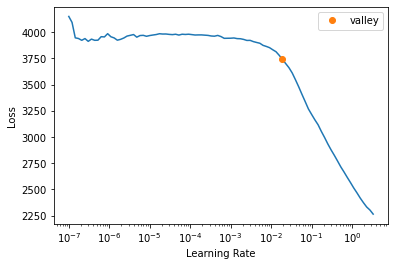

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   70.00      72.10
1   62.00      54.67
2   56.00      60.38
3   63.00      67.49
4   63.00      52.84
XGBoost RMSE:  21.504137


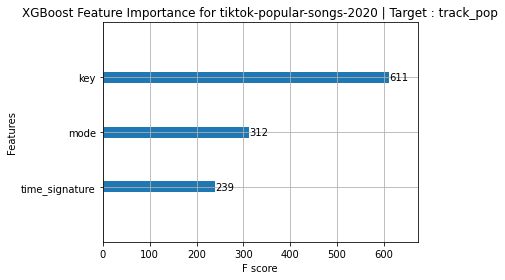

Target Variable: artist_pop
CATS=====================
['mode', 'key', 'time_signature']
CONTS=====================
['track_name', 'artist_name', 'album', 'track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_name_no_dollar']
18
Could not convert track_name to float.
Could not convert artist_name to float.
Could not convert album to float.
Could not convert track_name_no_dollar to float.
Looping through continuous variables to find breakpoint
Error with  track_name
Error with  artist_name
Error with  album
Error with  track_name_no_dollar
Continuous variables that made the cut : ['track_pop', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Categorical variables that made the cut : ['mode', 'key', 'time_signature']
Tabular Object size: 292


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.023161466656450802, 'Adjusted R-Squared': -0.08000377035958706, 'RMSE': 14.377590683716312, 'Time taken': 0.025483131408691406}
{'Model': 'BaggingRegressor', 'R-Squared': -0.14281541932652453, 'Adjusted R-Squared': -0.20630516484466477, 'RMSE': 15.195047895024064, 'Time taken': 0.027365922927856445}
{'Model': 'BayesianRidge', 'R-Squared': -4.7578633328049236e-05, 'Adjusted R-Squared': -0.055605777446290805, 'RMSE': 14.21426339924184, 'Time taken': 0.009459257125854492}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.13396908956935238, 'Adjusted R-Squared': -0.19696737232320527, 'RMSE': 15.136122566897455, 'Time taken': 0.008980512619018555}
{'Model': 'DummyRegressor', 'R-Squared': -7.000835003778683e-05, 'Adjusted R-Squared': -0.05562945325837321, 'RMSE': 14.214422, 'Time taken': 0.008188009262084961}
{'Model': 'ElasticNet', 'R-Squared': 0.0030255367580700465, 'Adjusted R-Squared': -0.0523619334220371, 'RMSE': 14.192406598305643, 'Time 

 17%|█▋        | 7/42 [00:00<00:00, 47.32it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.05900216102600098}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.13396908956935238, 'Adjusted R-Squared': -0.19696737232320527, 'RMSE': 15.136122566897455, 'Time taken': 0.011060476303100586}


 29%|██▊       | 12/42 [00:00<00:00, 34.94it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.12982134541086854, 'Adjusted R-Squared': -0.19258919793369467, 'RMSE': 15.108415339944816, 'Time taken': 0.11027216911315918}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.11048031893444032, 'Adjusted R-Squared': -0.17217366998635364, 'RMSE': 14.978539208297743, 'Time taken': 0.022160053253173828}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.015365551652708698, 'Adjusted R-Squared': -0.03933636214436298, 'RMSE': 14.104300119370754, 'Time taken': 0.028310537338256836}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.03750807957119118, 'Adjusted R-Squared': -0.01596369378596485, 'RMSE': 13.944809118906432, 'Time taken': 0.09463024139404297}


 38%|███▊      | 16/42 [00:00<00:01, 25.06it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.017732451296847307, 'Adjusted R-Squared': -0.036837968075550176, 'RMSE': 14.08733770797511, 'Time taken': 0.11431646347045898}
{'Model': 'HuberRegressor', 'R-Squared': 0.007722112029030281, 'Adjusted R-Squared': -0.04740443730269028, 'RMSE': 14.158938142158528, 'Time taken': 0.013571977615356445}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.3204974827022351, 'Adjusted R-Squared': -0.3938584539634704, 'RMSE': 16.333633, 'Time taken': 0.010475635528564453}
{'Model': 'KernelRidge', 'R-Squared': -22.44648077477328, 'Adjusted R-Squared': -23.749063040038465, 'RMSE': 68.82605237366879, 'Time taken': 0.020886659622192383}
{'Model': 'Lars', 'R-Squared': 0.033257164702310216, 'Adjusted R-Squared': -0.02045077059200584, 'RMSE': 13.97556931943535, 'Time taken': 0.014414072036743164}
{'Model': 'LarsCV', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.0266518592

 50%|█████     | 21/42 [00:00<00:00, 25.69it/s]

{'Model': 'LassoCV', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.09465694427490234}
{'Model': 'LassoLars', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.010200977325439453}
{'Model': 'LassoLarsCV', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.017078638076782227}
{'Model': 'LassoLarsIC', 'R-Squared': -7.000098002896138e-05, 'Adjusted R-Squared': -0.05562944547891946, 'RMSE': 14.214422749337954, 'Time taken': 0.010617733001708984}
{'Model': 'LinearRegression', 'R-Squared': 0.033257164702310216, 'Adjusted R-Squared': -0.02045077059200584, 'RMSE': 13.97556931943535, 'Time taken': 0.009336233139038086}
{'Model': 'LinearSVR', 'R-Squared': -0.04392261125491448, 'Adjusted R-Squared': -0.10191831188018763, 'RMSE': 14.5227272113921, 'Time taken': 0.00980615615

 79%|███████▊  | 33/42 [00:01<00:00, 17.45it/s]

{'Model': 'MLPRegressor', 'R-Squared': -6.72650359993645, 'Adjusted R-Squared': -7.155753799932919, 'RMSE': 39.50986386210838, 'Time taken': 0.7461967468261719}
{'Model': 'NuSVR', 'R-Squared': 0.01762189957533855, 'Adjusted R-Squared': -0.036954661559364776, 'RMSE': 14.088130432737236, 'Time taken': 0.019532203674316406}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.010677351598663565, 'Adjusted R-Squared': -0.04428501775696625, 'RMSE': 14.137838077403039, 'Time taken': 0.014162302017211914}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.010677351598663565, 'Adjusted R-Squared': -0.04428501775696625, 'RMSE': 14.137838077403039, 'Time taken': 0.02077198028564453}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.006793569136710476, 'Adjusted R-Squared': -0.0627265451998611, 'RMSE': 14.262125181881132, 'Time taken': 0.013902664184570312}
{'Model': 'PoissonRegressor', 'R-Squared': 0.03277719596115036, 'Adjusted R-Squared': -0.020957404263230117, 'RMSE': 13.979038186

100%|██████████| 42/42 [00:01<00:00, 21.26it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.09584638441521154, 'Adjusted R-Squared': -0.1567267391049456, 'RMSE': 14.879518138322524, 'Time taken': 0.15001225471496582}
{'Model': 'Ridge', 'R-Squared': 0.03309437519501268, 'Adjusted R-Squared': -0.02062260396081994, 'RMSE': 13.976745940659674, 'Time taken': 0.00980377197265625}
{'Model': 'RidgeCV', 'R-Squared': 0.03169676475371619, 'Adjusted R-Squared': -0.022097859426633004, 'RMSE': 13.986843612967592, 'Time taken': 0.009580612182617188}
{'Model': 'SGDRegressor', 'R-Squared': 0.03328844790055818, 'Adjusted R-Squared': -0.02041774943829977, 'RMSE': 13.97534319723065, 'Time taken': 0.011387825012207031}
{'Model': 'SVR', 'R-Squared': 0.0007126652705068404, 'Adjusted R-Squared': -0.054803297770020576, 'RMSE': 14.20885947553447, 'Time taken': 0.01305842399597168}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.033257164702310216, 'Adjusted R-Squared': -0.02045077059200584, 'RMSE': 13.97556931943535, 'Time taken': 0.01003050804

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4838.702637,4681.918457,68.424545,00:00
1,4478.550781,4293.657227,65.526001,00:00
2,3932.921387,3098.426270,55.663509,00:00
3,3201.874023,723.618103,26.900150,00:00
4,2609.679932,432.830383,20.804577,00:00
5,2209.140625,277.410278,16.655638,00:00
6,1896.971802,382.312225,19.552807,00:00


Better model found at epoch 0 with _rmse value: 68.42454528808594.
Better model found at epoch 1 with _rmse value: 65.5260009765625.
Better model found at epoch 2 with _rmse value: 55.663509368896484.
Better model found at epoch 3 with _rmse value: 26.900150299072266.
Better model found at epoch 4 with _rmse value: 20.804576873779297.
Better model found at epoch 5 with _rmse value: 16.655637741088867.
No improvement since epoch 5: early stopping


,mode,key,time_signature,artist_pop,artist_pop_pred
0,1.00,7.00,3.00,60.00,66.25
1,1.00,1.00,3.00,93.00,70.97
2,1.00,10.00,3.00,56.00,62.00
3,2.00,6.00,3.00,75.00,57.22
4,1.00,7.00,3.00,78.00,66.25
5,2.00,12.00,3.00,71.00,57.84
6,2.00,3.00,3.00,29.00,64.45
7,2.00,8.00,3.00,42.00,61.69
8,2.00,1.00,3.00,88.00,62.29


<Figure size 432x288 with 0 Axes>

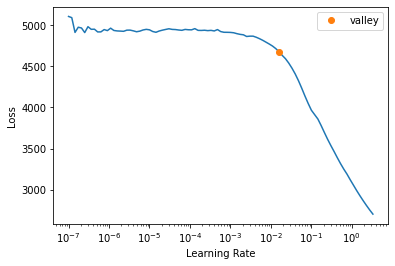

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   86.00      59.50
1   71.00      82.25
2   40.00      75.46
3   63.00      69.00
4   62.00      69.00
XGBoost RMSE:  14.997124


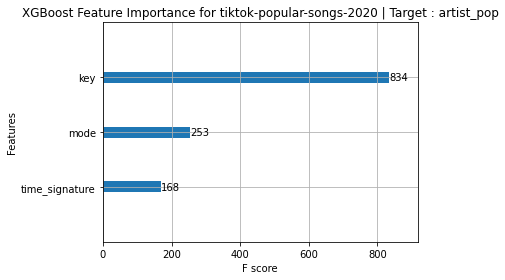

<Figure size 432x288 with 0 Axes>

In [15]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

          feature  importance
0  time_signature         102
1             key         452
2            mode         214
0             key         299
1  time_signature          40


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

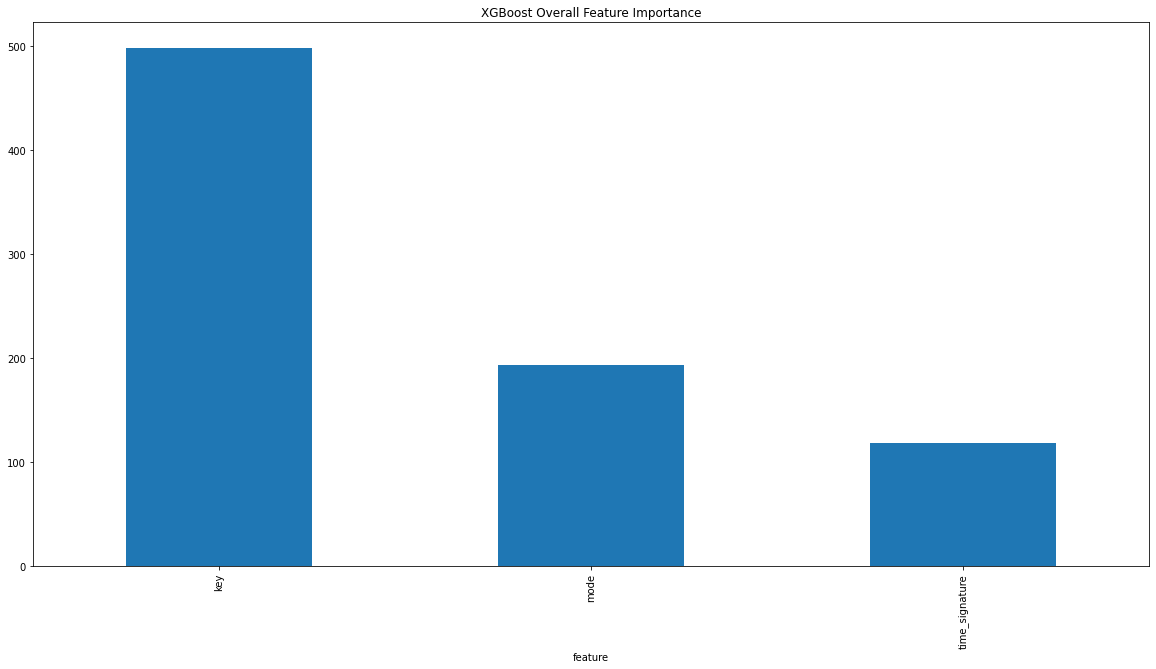

In [16]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [17]:
df.isna().sum()

track_name              0
artist_name             0
artist_pop              0
album                   0
track_pop               0
danceability            0
energy                  0
loudness                0
mode                    0
key                     0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
duration_ms             0
track_name_no_dollar    0
dtype: int64

# **To Be Continued...**